In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
#file = open("sim_data_no_noise_50frames.pkl", "rb")

#sim_data = pickle.load(file)

#file.close()


In [3]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [4]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


## Setting up the target

In [5]:
target_model_1 = mmars.Target(start_position=np.array([[10.001,10.001]]), start_velocity=1., T_total=10., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

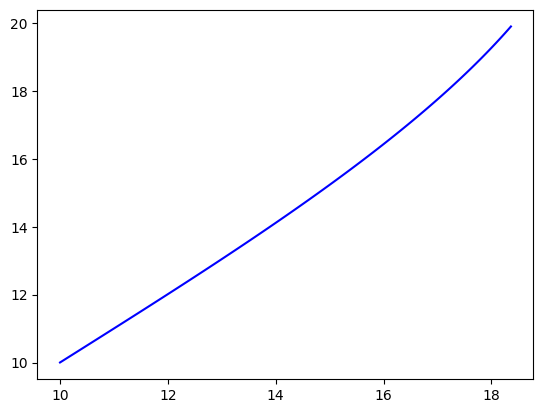

In [6]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [7]:
simulation_data = mmars.Simulation(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x0000018B1B18EE80> and <mmars.target.Target object at 0x0000018B1B18ED60>


100%|██████████| 100/100 [00:00<00:00, 1058.46it/s]


In [8]:
sim_data = simulation_data.get_data()

In [9]:
frame = 5

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

10.50079169270678 10.500999999999998


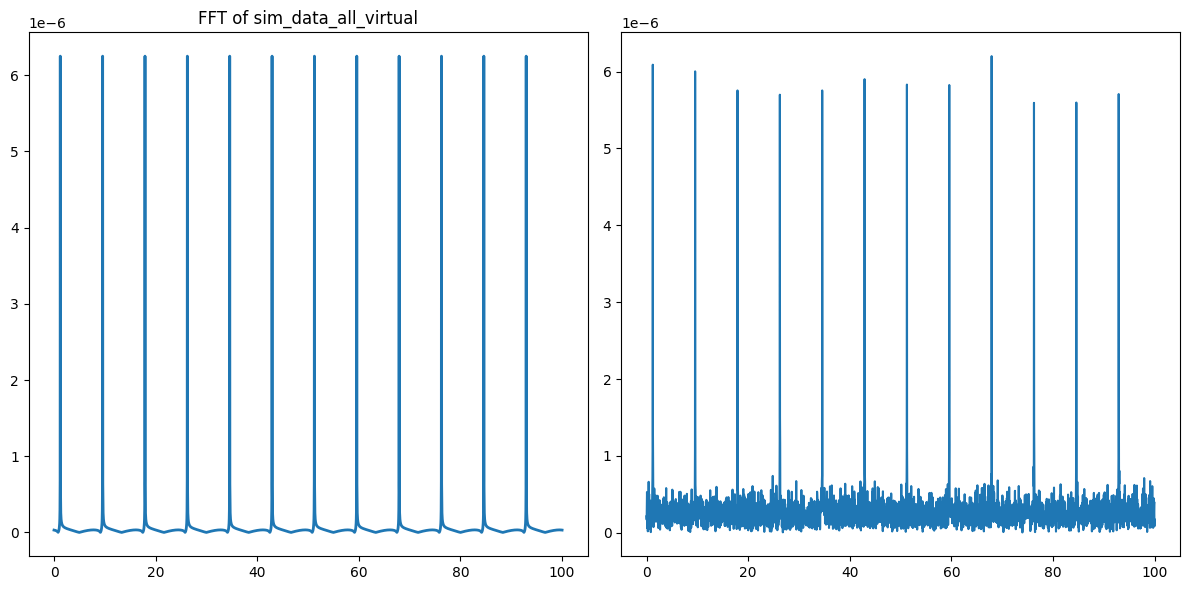

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=2)
axs[1].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T))

#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')


#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

In [11]:
mrblatcomp = mmars.MRBLaT_Functions()

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


In [12]:
np.abs(mrblatcomp.alpha_hat(S_N, data_fourier.T))

array([[0.83354867]])

In [13]:
mrblatcomp.jacobian_S(np.array([5.5, 5.5]))

array([[ 3.40693854e-05+0.00000000e+00j,  3.40693854e-05+0.00000000e+00j],
       [ 3.58808213e-05-4.42073051e-07j,  3.58808213e-05-4.42073051e-07j],
       [ 3.78701364e-05-9.33306864e-07j,  3.78701364e-05-9.33306864e-07j],
       ...,
       [-3.00275866e-05-8.60227682e-06j, -2.61899826e-05-1.70217488e-05j],
       [-3.08226086e-05-1.04347351e-05j, -2.84906262e-05-1.57226308e-05j],
       [-3.17242349e-05-1.24602311e-05j, -3.09551048e-05-1.42641483e-05j]])

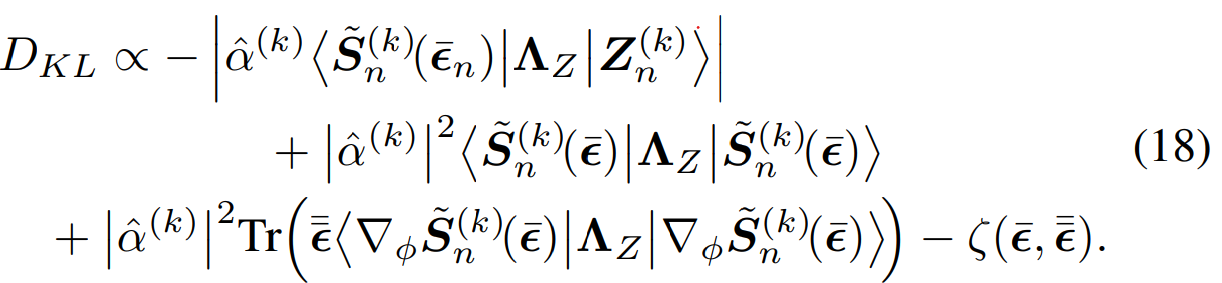

In [107]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

def D_KL(params, Z_data, phi_bar_last_x, phi_bar_last_y):
    eps_bar_x, eps_bar_y, eps_barbar_0, eps_barbar_1 = params

    # Last estimate of the trajectory
    radar_model_1.generate_S_signal(phi_bar_last_x, phi_bar_last_y)
    S_N_lack = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

    # Generate the S signal with the new parameters
    radar_model_1.generate_S_signal(eps_bar_x, eps_bar_y)
    s_n = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)
    
    # Compute the alpha_hat value
    alpha_hat_xy = np.abs(mrblatcomp.alpha_hat(S_N_lack, Z_data))

    
    s_n_H = s_n.conj().T

    term_1 = -np.abs(alpha_hat_xy * (s_n_H @ Lambda_z @ Z_data))
    term_2 = np.real(np.abs(alpha_hat_xy)**2 * s_n_H @ Lambda_z @ s_n)
    
    jac = mrblatcomp.jacobian_S(np.array([eps_bar_x, eps_bar_y]))
    term_3_inner_prod = np.real(jac.conj().T @ Lambda_z @ jac)
    
    term_3 = np.abs(alpha_hat_xy)**2 * np.trace(np.array([[eps_barbar_0, 0], [0, eps_barbar_1]]) * term_3_inner_prod)
    k = 2
    entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)
    
    print(term_1, term_2, term_3, entropy)

    return alpha_hat_xy

In [100]:
frame = 30

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [101]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]
print(last_frame_x, last_frame_y)

result = minimize(D_KL, (last_frame_x, last_frame_y, 0.5, 0.5), bounds = [(1,20), (1,20), (0, 10), (0, 10)],  args=(data_fourier, last_frame_x, last_frame_y), method='nelder-mead')

12.860522251048344 12.90099999999999
[[-327.52359425]] [[327.52359425]] [[2010756.56924275]] 2.1447298858494
[[-608.09010153]] [[298.50625083]] [[1718709.56353423]] 2.1447298858494
[[-605.27765453]] [[298.50460484]] [[1804116.54088966]] 2.1447298858494
[[-327.52359425]] [[327.52359425]] [[2061031.09900719]] 2.169124967934116
[[-327.52359425]] [[327.52359425]] [[2061019.86794044]] 2.169124967934116
[[-632.96809974]] [[298.51826549]] [[1743814.82358796]] 2.1314295449508105
[[-19.02928741]] [[287.78758572]] [[1594086.95224857]] 2.110456614581845
[[-19.02928741]] [[287.78758572]] [[1594099.7314292]] 2.112960375447156
[[-805.8924739]] [[324.84996042]] [[1890711.72654886]] 2.1554634568284023
[[-143.60843927]] [[277.8671656]] [[1632039.3602291]] 2.1435737651075772
[[-842.7467748]] [[323.90699999]] [[1856385.54124101]] 2.144511179576674
[[-812.7729982]] [[323.91506228]] [[1780896.26355328]] 2.1433763938786496
[[-471.07529637]] [[325.21713167]] [[1990460.04944698]] 2.142342134460204
[[-843.8099

In [98]:
print(f"{result.x}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

[13.06498323 13.09737373  0.27332955  0.2733617 ]
(np.float64(12.956202066613384), np.float64(13.000999999999989))


In [93]:
bounds = [(0,50), (0,50), (0.01, 10), (0.01, 10)]

result = differential_evolution(D_KL, bounds, args=(data_fourier, last_frame_x, last_frame_y))

In [73]:
np.sqrt(result.x[2]), np.sqrt(result.x[3])

(np.float64(1.7149221890055524), np.float64(1.128479085184062))

In [74]:
target_ground_truth[0][0]

np.float64(10.001)

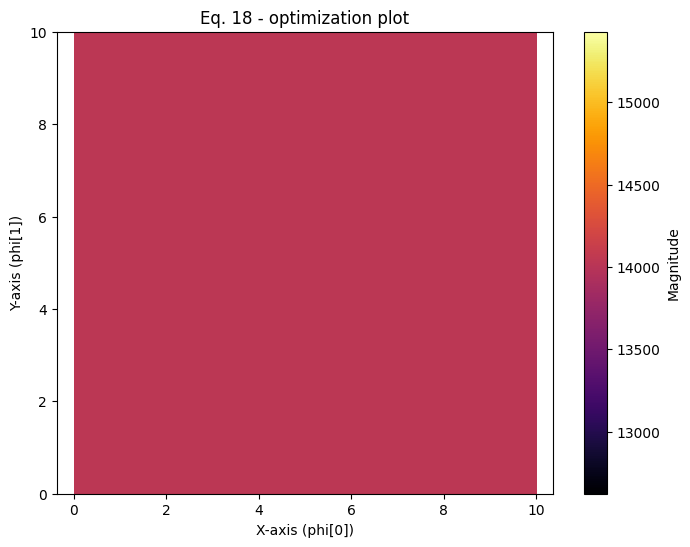

In [75]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = D_KL(
            np.array([5.5, 5.5, i, j]),
            data_fourier,
            target_model_1.get_trajectory()[0][frame-1],
            target_model_1.get_trajectory()[0][frame-1]
        )
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [76]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(0), np.int64(0))


np.float64(14025.543139649468)

In [102]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [4.941e-01],  [4.686e-01]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [103]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1]))

  0%|          | 49/10000 [00:00<00:20, 483.87it/s]

[[-1.74804344e+11]] [[9.51693829e+22]] [[4.81923799e+36]] 2.106365513389908
[[-9607.98209736]] [[2.99234602e+08]] [[1.40992571e+12]] 2.106365513389908
[[-2734.41091721]] [[18065245.34659959]] [[6.10058477e+10]] 2.106365513389908
[[-510.37912746]] [[3608481.41147627]] [[1.0413585e+10]] 2.106365513389908
[[-515.79816943]] [[1140571.48467771]] [[3.21637804e+09]] 2.106365513389908
[[-764.88918156]] [[456940.73331022]] [[1.36840246e+09]] 2.106365513389908
[[-335.96651653]] [[222850.53604]] [[6.27033794e+08]] 2.106365513389908
[[-534.12514227]] [[122287.72269752]] [[3.22635671e+08]] 2.106365513389908
[[-160.59097144]] [[70240.62185505]] [[2.00822076e+08]] 2.106365513389908
[[-178.85294708]] [[43534.04378406]] [[1.26632972e+08]] 2.106365513389908
[[-90.53853879]] [[29256.53807872]] [[77282443.16353488]] 2.106365513389908
[[-190.90124339]] [[19891.16528294]] [[53796726.2441596]] 2.106365513389908
[[-79.81653523]] [[13737.35680374]] [[40325898.78487942]] 2.106365513389908
[[-86.54062316]] [[101

  1%|▏         | 147/10000 [00:00<00:20, 484.83it/s]

[[-2.6935006]] [[3.31692657]] [[8578.70509956]] 2.106365513389908
[[-2.3954117]] [[3.11994843]] [[8754.78714298]] 2.106365513389908
[[-2.5526984]] [[2.97042007]] [[8606.91268347]] 2.106365513389908
[[-10260.36857012]] [[2.99234602e+08]] [[2.43832718e+15]] 2.106365513389908
[[-10899.34993553]] [[73252932.45983994]] [[1.45572532e+14]] 2.106365513389908
[[-2986.91641727]] [[11705780.51414909]] [[3.69288301e+12]] 2.106365513389908
[[-854.23609388]] [[2932579.2168131]] [[2.36176515e+11]] 2.106365513389908
[[-317.29934145]] [[997097.67718682]] [[2.96884834e+10]] 2.106365513389908
[[-896.28737916]] [[422534.22343724]] [[6.09383348e+09]] 2.106365513389908
[[-393.38811706]] [[212972.83462623]] [[1.78084085e+09]] 2.106365513389908
[[-448.0465606]] [[117053.7339168]] [[6.75848918e+08]] 2.106365513389908
[[-163.88320104]] [[67672.19623599]] [[3.21519086e+08]] 2.106365513389908
[[-176.14066917]] [[42694.20809012]] [[1.70658275e+08]] 2.106365513389908
[[-74.62873911]] [[28765.50569167]] [[96947320.6

  2%|▏         | 245/10000 [00:00<00:20, 483.03it/s]

[[-4.02491285]] [[3.3967454]] [[9421.58344725]] 2.106365513389908
[[-2.71688119]] [[3.31603086]] [[8578.84682685]] 2.106365513389908
[[-2.39046447]] [[3.11739444]] [[8768.60119184]] 2.106365513389908
[[-2.56509016]] [[2.97085804]] [[8596.7311654]] 2.106365513389908
[[-298.82668527]] [[18065245.34659959]] [[3.68463359e+13]] 2.106365513389908
[[-1430.35077366]] [[11705780.51414911]] [[1.51323018e+13]] 2.106365513389908
[[-2273.76109023]] [[4498346.35657459]] [[2.24456496e+12]] 2.106365513389908
[[-830.49322504]] [[1700033.30860135]] [[3.21082776e+11]] 2.106365513389908
[[-1201.2329111]] [[724401.46900961]] [[5.86071861e+10]] 2.106365513389908
[[-880.39795055]] [[348742.20283749]] [[1.38387063e+10]] 2.106365513389908
[[-741.99301609]] [[182437.8698034]] [[4.03802992e+09]] 2.106365513389908
[[-195.90393067]] [[101855.49352601]] [[1.42214747e+09]] 2.106365513389908
[[-173.89858477]] [[61885.56901342]] [[5.93391551e+08]] 2.106365513389908
[[-164.52028107]] [[40477.73050416]] [[2.80576006e+08

  3%|▎         | 343/10000 [00:00<00:20, 462.63it/s]

[[-3.65180653]] [[4.18972457]] [[11788.33939525]] 2.106365513389908
[[-2.60053413]] [[3.98063814]] [[11519.45987147]] 2.106365513389908
[[-2.43295985]] [[3.90662579]] [[10264.45514834]] 2.106365513389908
[[-2.29501923]] [[3.72729792]] [[9970.75430782]] 2.106365513389908
[[-3.18019814]] [[3.4934544]] [[10200.24294641]] 2.106365513389908
[[-4.06441569]] [[3.4012097]] [[9361.92967031]] 2.106365513389908
[[-2.78430212]] [[3.31282101]] [[8583.53249964]] 2.106365513389908
[[-2.37531452]] [[3.10992672]] [[8808.44125431]] 2.106365513389908
[[-2.60128493]] [[2.97255058]] [[8563.14961318]] 2.106365513389908
[[-1866.00376992]] [[3608481.41147627]] [[3.27604464e+12]] 2.106365513389908
[[-2611.48368754]] [[2932579.21681311]] [[2.14682388e+12]] 2.106365513389908
[[-1899.95346154]] [[1700033.30860135]] [[7.30673233e+11]] 2.106365513389908
[[-997.04679199]] [[881617.65221047]] [[1.9694872e+11]] 2.106365513389908
[[-484.6967533]] [[456910.17496699]] [[5.31729425e+10]] 2.106365513389908
[[-740.42166988]

  4%|▍         | 440/10000 [00:00<00:20, 473.82it/s]

[[-1.20158426]] [[4.60538701]] [[12596.43531931]] 2.106365513389908
[[-2.20158208]] [[4.46194134]] [[11586.04521581]] 2.106365513389908
[[-3.73323325]] [[4.17170411]] [[11880.91623355]] 2.106365513389908
[[-2.56104319]] [[3.98488707]] [[11434.03865527]] 2.106365513389908
[[-2.2825604]] [[3.90971129]] [[10193.48112815]] 2.106365513389908
[[-2.35581873]] [[3.71161853]] [[10054.61110726]] 2.106365513389908
[[-3.18987997]] [[3.48794024]] [[10202.72603574]] 2.106365513389908
[[-4.11344366]] [[3.40859114]] [[9263.20559379]] 2.106365513389908
[[-2.88743144]] [[3.30577834]] [[8605.10470864]] 2.106365513389908
[[-2.34885357]] [[3.0983048]] [[8868.05731333]] 2.106365513389908
[[-2.65809012]] [[2.97650842]] [[8498.07226468]] 2.106365513389908
[[-1343.49178954]] [[1140571.48467771]] [[5.83779342e+11]] 2.106365513389908
[[-607.16925483]] [[997097.67718682]] [[4.51132559e+11]] 2.106365513389908
[[-423.25974524]] [[724401.46900961]] [[2.35570973e+11]] 2.106365513389908
[[-417.92469984]] [[456910.1749

  6%|▌         | 587/10000 [00:01<00:19, 481.63it/s]

[[-1.04689185]] [[4.61913577]] [[12400.4167385]] 2.106365513389908
[[-2.19304818]] [[4.44404276]] [[11653.80054519]] 2.106365513389908
[[-3.83581089]] [[4.14963321]] [[11984.59468425]] 2.106365513389908
[[-2.54894139]] [[3.99415454]] [[11287.97860604]] 2.106365513389908
[[-2.07610891]] [[3.90981966]] [[10128.67304723]] 2.106365513389908
[[-2.41712979]] [[3.68864935]] [[10180.00414048]] 2.106365513389908
[[-3.16864719]] [[3.48440869]] [[10172.27599791]] 2.106365513389908
[[-4.14659732]] [[3.41798494]] [[9133.07681324]] 2.106365513389908
[[-3.01186822]] [[3.2926637]] [[8661.69919289]] 2.106365513389908
[[-2.30873659]] [[3.08433807]] [[8932.65236613]] 2.106365513389908
[[-2.72932451]] [[2.98392201]] [[8392.05776061]] 2.106365513389908
[[-1060.0287544]] [[456940.73331022]] [[1.501994e+11]] 2.106365513389908
[[-841.02357223]] [[422534.22343724]] [[1.2823922e+11]] 2.106365513389908
[[-1131.36258307]] [[348742.20283749]] [[8.47425695e+10]] 2.106365513389908
[[-400.79553626]] [[246637.6236343]

  7%|▋         | 686/10000 [00:01<00:19, 484.24it/s]

[[-0.84147103]] [[4.98612891]] [[14050.16559511]] 2.106365513389908
[[-0.81438335]] [[4.72911521]] [[13697.04787678]] 2.106365513389908
[[-0.86700244]] [[4.6321694]] [[12187.34916695]] 2.106365513389908
[[-2.14479624]] [[4.41352315]] [[11801.5878814]] 2.106365513389908
[[-3.94900119]] [[4.12866408]] [[12057.43933156]] 2.106365513389908
[[-2.60940334]] [[4.00947908]] [[11073.47005745]] 2.106365513389908
[[-1.82216366]] [[3.90201769]] [[10110.22315753]] 2.106365513389908
[[-2.45265701]] [[3.65964958]] [[10336.40632056]] 2.106365513389908
[[-3.08046034]] [[3.48667584]] [[10078.18594139]] 2.106365513389908
[[-4.12869225]] [[3.4266467]] [[8994.21420816]] 2.106365513389908
[[-3.13710625]] [[3.27133334]] [[8770.54381444]] 2.106365513389908
[[-2.25094392]] [[3.07140586]] [[8974.73924713]] 2.106365513389908
[[-2.80478767]] [[2.99522799]] [[8241.92939492]] 2.106365513389908
[[-597.12814377]] [[222850.53604]] [[5.10255444e+10]] 2.106365513389908
[[-675.57597354]] [[212972.83462623]] [[4.61096557e

  8%|▊         | 784/10000 [00:01<00:19, 484.62it/s]

[[-4.20053881]] [[5.29974246]] [[13912.21340056]] 2.106365513389908
[[-0.67377097]] [[4.93977057]] [[14273.09534925]] 2.106365513389908
[[-1.23770512]] [[4.74364882]] [[13435.11645009]] 2.106365513389908
[[-0.68332706]] [[4.63600134]] [[12026.6835096]] 2.106365513389908
[[-2.03258168]] [[4.36952957]] [[12035.73181874]] 2.106365513389908
[[-4.06033871]] [[4.11660019]] [[12036.34663974]] 2.106365513389908
[[-2.78496316]] [[4.02835436]] [[10811.70281399]] 2.106365513389908
[[-1.53552899]] [[3.88058623]] [[10184.40077989]] 2.106365513389908
[[-2.42757207]] [[3.62927662]] [[10485.72130921]] 2.106365513389908
[[-2.87985231]] [[3.49781146]] [[9896.12958464]] 2.106365513389908
[[-4.01687962]] [[3.42921229]] [[8890.47573213]] 2.106365513389908
[[-3.23768316]] [[3.24140585]] [[8934.38250391]] 2.106365513389908
[[-2.16992647]] [[3.06442118]] [[8954.57955829]] 2.106365513389908
[[-2.86931945]] [[3.00868429]] [[8062.31836314]] 2.106365513389908
[[-181.63191752]] [[122287.72269752]] [[2.06378003e+10

  8%|▊         | 833/10000 [00:01<00:19, 481.82it/s]

[[-2.02306445]] [[5.66796865]] [[16285.78997516]] 2.106365513389908
[[-0.66727986]] [[5.53859957]] [[14474.96815982]] 2.106365513389908
[[-3.70573484]] [[5.24133778]] [[14198.55918816]] 2.106365513389908
[[-0.52564814]] [[4.90534733]] [[14370.41869133]] 2.106365513389908
[[-1.70896141]] [[4.77073913]] [[13047.90093459]] 2.106365513389908
[[-0.52124633]] [[4.6187763]] [[12014.5807148]] 2.106365513389908
[[-1.8401853]] [[4.3180899]] [[12306.55578625]] 2.106365513389908
[[-4.15495526]] [[4.12132114]] [[11858.28311162]] 2.106365513389908
[[-3.08586942]] [[4.04234917]] [[10571.89979076]] 2.106365513389908
[[-1.2347571]] [[3.84218901]] [[10377.6646469]] 2.106365513389908
[[-2.3032721]] [[3.60631236]] [[10556.69022278]] 2.106365513389908
[[-2.51728737]] [[3.51713181]] [[9632.58672974]] 2.106365513389908
[[-3.7657991]] [[3.41831889]] [[8881.60486694]] 2.106365513389908
[[-3.28629199]] [[3.20658316]] [[9122.7267257]] 2.106365513389908
[[-2.06035357]] [[3.06833355]] [[8832.51644342]] 2.106365513

  9%|▉         | 931/10000 [00:01<00:18, 483.62it/s]

[[-1.41617618]] [[6.67055383]] [[17525.17718395]] 2.106365513389908
[[-2.3081866]] [[6.3163982]] [[17010.17425437]] 2.106365513389908
[[-1.32111227]] [[5.8905175]] [[17255.36009622]] 2.106365513389908
[[-2.39561765]] [[5.70220083]] [[15754.63298322]] 2.106365513389908
[[-1.2272518]] [[5.5256797]] [[14351.32772751]] 2.106365513389908
[[-3.00377594]] [[5.16462975]] [[14602.22409283]] 2.106365513389908
[[-0.60502199]] [[4.89950727]] [[14208.54361931]] 2.106365513389908
[[-2.17162814]] [[4.79674132]] [[12647.81817539]] 2.106365513389908
[[-0.40333021]] [[4.57162199]] [[12221.90666999]] 2.106365513389908
[[-1.58781826]] [[4.27460123]] [[12488.84556552]] 2.106365513389908
[[-4.21245304]] [[4.1444311]] [[11511.952161]] 2.106365513389908
[[-3.46907894]] [[4.0375326]] [[10467.27542549]] 2.106365513389908
[[-0.93539251]] [[3.791086]] [[10654.48158007]] 2.106365513389908
[[-2.05266141]] [[3.6012124]] [[10465.21883069]] 2.106365513389908
[[-1.95197395]] [[3.5367494]] [[9352.56387959]] 2.1063655133

 10%|█         | 1029/10000 [00:02<00:19, 453.63it/s]

[[-2.66076683]] [[6.88573992]] [[19016.32732237]] 2.106365513389908
[[-0.78882417]] [[6.65422893]] [[17316.59820878]] 2.106365513389908
[[-2.37589371]] [[6.20610235]] [[17579.61536264]] 2.106365513389908
[[-1.7750024]] [[5.87557696]] [[17066.10593172]] 2.106365513389908
[[-2.66764261]] [[5.73988677]] [[15168.89981037]] 2.106365513389908
[[-1.97974799]] [[5.46317146]] [[14600.09605784]] 2.106365513389908
[[-2.11756838]] [[5.0974503]] [[14896.64586233]] 2.106365513389908
[[-0.90661466]] [[4.92736131]] [[13749.2353511]] 2.106365513389908
[[-2.54064172]] [[4.795878]] [[12444.41503288]] 2.106365513389908
[[-0.38492818]] [[4.50012707]] [[12601.34345386]] 2.106365513389908
[[-1.3986753]] [[4.25922854]] [[12420.20519779]] 2.106365513389908
[[-4.20051296]] [[4.1733735]] [[11101.19174068]] 2.106365513389908
[[-3.84280384]] [[4.00140447]] [[10598.17938839]] 2.106365513389908
[[-0.65758664]] [[3.74310271]] [[10885.83254223]] 2.106365513389908
[[-1.70263892]] [[3.6186934]] [[10174.76638891]] 2.1063

 11%|█         | 1124/10000 [00:02<00:19, 463.42it/s]

[[-0.92582639]] [[8.68550728]] [[25577.90084681]] 2.106365513389908
[[-3.07757158]] [[8.40804397]] [[22937.06581621]] 2.106365513389908
[[-3.01647976]] [[8.06737831]] [[21143.61384557]] 2.106365513389908
[[-3.78623598]] [[7.49377522]] [[21505.75057803]] 2.106365513389908
[[-2.02212941]] [[7.11267528]] [[20548.30820377]] 2.106365513389908
[[-3.00185319]] [[6.93178869]] [[18231.44243011]] 2.106365513389908
[[-0.55975444]] [[6.55837896]] [[17713.49539204]] 2.106365513389908
[[-2.47989654]] [[6.11554204]] [[17946.26125997]] 2.106365513389908
[[-2.05632384]] [[5.91504698]] [[16405.82696805]] 2.106365513389908
[[-2.73653548]] [[5.7337371]] [[14912.4618702]] 2.106365513389908
[[-2.85406359]] [[5.36255702]] [[15124.26484718]] 2.106365513389908
[[-1.15416886]] [[5.07622909]] [[14788.71424224]] 2.106365513389908
[[-1.19191321]] [[4.96585164]] [[13183.09338525]] 2.106365513389908
[[-2.71349401]] [[4.74545941]] [[12619.5561438]] 2.106365513389908
[[-0.58743526]] [[4.43262781]] [[12921.8128122]] 2.

 13%|█▎        | 1271/10000 [00:02<00:18, 477.35it/s]

[[-6.35009576]] [[9.82967648]] [[26321.90193991]] 2.106365513389908
[[-1.31102112]] [[9.10575587]] [[26672.41281446]] 2.106365513389908
[[-0.70747155]] [[8.70955163]] [[24708.00502462]] 2.106365513389908
[[-2.92244441]] [[8.44189495]] [[22060.2194789]] 2.106365513389908
[[-3.09176809]] [[7.90518505]] [[21895.46594161]] 2.106365513389908
[[-4.05970095]] [[7.39414867]] [[21772.58933332]] 2.106365513389908
[[-2.11174276]] [[7.17540209]] [[19546.65018858]] 2.106365513389908
[[-3.19903267]] [[6.8950911]] [[18083.53741638]] 2.106365513389908
[[-1.18121342]] [[6.41750625]] [[18429.21025741]] 2.106365513389908
[[-2.48712166]] [[6.10403452]] [[17634.88660382]] 2.106365513389908
[[-2.03605299]] [[5.95961171]] [[15680.08543462]] 2.106365513389908
[[-2.53134628]] [[5.65020608]] [[15252.37784728]] 2.106365513389908
[[-3.74034711]] [[5.27769932]] [[15485.49616964]] 2.106365513389908
[[-0.50376904]] [[5.11112349]] [[14202.11056905]] 2.106365513389908
[[-1.25881342]] [[4.96537727]] [[12912.90714685]] 

 14%|█▎        | 1369/10000 [00:02<00:18, 478.82it/s]

[[-3.83511408]] [[10.80816473]] [[29568.67826815]] 2.106365513389908
[[-1.01971353]] [[10.32871167]] [[27254.94858613]] 2.106365513389908
[[-6.13013591]] [[9.57035547]] [[27581.06419889]] 2.106365513389908
[[-2.10493848]] [[9.04828395]] [[26343.50459538]] 2.106365513389908
[[-1.0943709]] [[8.79110231]] [[23335.25330092]] 2.106365513389908
[[-2.39277504]] [[8.31924714]] [[22402.11360572]] 2.106365513389908
[[-2.53793694]] [[7.72866703]] [[22699.02136236]] 2.106365513389908
[[-3.6777339]] [[7.42393987]] [[20948.46148797]] 2.106365513389908
[[-1.77433548]] [[7.20229561]] [[18806.67887974]] 2.106365513389908
[[-3.20332436]] [[6.7486366]] [[18780.44751761]] 2.106365513389908
[[-1.82404261]] [[6.33355749]] [[18638.08042501]] 2.106365513389908
[[-2.21705119]] [[6.1625663]] [[16729.66534718]] 2.106365513389908
[[-1.6928039]] [[5.92548812]] [[15566.07528381]] 2.106365513389908
[[-2.03838467]] [[5.52419007]] [[15898.92817936]] 2.106365513389908
[[-4.44746705]] [[5.26905371]] [[15199.09163513]] 2

 15%|█▍        | 1467/10000 [00:03<00:17, 480.56it/s]

[[-3.29838847]] [[11.71221781]] [[34823.1168685]] 2.106365513389908
[[-3.81054323]] [[11.26107299]] [[31417.02569168]] 2.106365513389908
[[-2.9263766]] [[10.81654159]] [[28468.83813478]] 2.106365513389908
[[-1.10076495]] [[10.04990815]] [[28542.36252901]] 2.106365513389908
[[-5.04064419]] [[9.42769595]] [[27813.35340014]] 2.106365513389908
[[-2.38730382]] [[9.1420559]] [[24750.50799154]] 2.106365513389908
[[-1.66435799]] [[8.72216562]] [[23139.93556459]] 2.106365513389908
[[-1.45513349]] [[8.09456704]] [[23502.08942398]] 2.106365513389908
[[-1.28116732]] [[7.69894155]] [[22261.19578323]] 2.106365513389908
[[-2.6523518]] [[7.49289268]] [[19780.69432703]] 2.106365513389908
[[-1.12354924]] [[7.08253726]] [[19215.04113432]] 2.106365513389908
[[-2.93608555]] [[6.60091009]] [[19435.60893168]] 2.106365513389908
[[-2.21562592]] [[6.36964899]] [[17842.47920916]] 2.106365513389908
[[-1.57242327]] [[6.18048347]] [[16132.00064203]] 2.106365513389908
[[-1.34123711]] [[5.79189786]] [[16221.48440895]

 16%|█▌        | 1565/10000 [00:03<00:17, 483.07it/s]

[[-5.28420664]] [[13.22121317]] [[36740.16694406]] 2.106365513389908
[[-5.94003542]] [[12.25492849]] [[36545.76308887]] 2.106365513389908
[[-3.9607038]] [[11.75344728]] [[33149.21357776]] 2.106365513389908
[[-4.37929542]] [[11.30790726]] [[29844.64343255]] 2.106365513389908
[[-1.94247655]] [[10.52765744]] [[29691.96757516]] 2.106365513389908
[[-3.05332128]] [[9.83728942]] [[29200.19482136]] 2.106365513389908
[[-3.20449468]] [[9.51384024]] [[26150.38305147]] 2.106365513389908
[[-2.12878031]] [[9.11764196]] [[24080.22269032]] 2.106365513389908
[[-2.26359606]] [[8.47139397]] [[24347.10223266]] 2.106365513389908
[[-0.88039002]] [[8.00322743]] [[23460.08388275]] 2.106365513389908
[[-0.73060412]] [[7.78560073]] [[20854.27420013]] 2.106365513389908
[[-1.48540636]] [[7.40951369]] [[19812.8282486]] 2.106365513389908
[[-0.93739996]] [[6.89087548]] [[20149.71997571]] 2.106365513389908
[[-2.28868777]] [[6.59569957]] [[18897.22081462]] 2.106365513389908
[[-2.37256231]] [[6.42452641]] [[16875.820728

 17%|█▋        | 1664/10000 [00:03<00:17, 483.54it/s]

[[-3.91066006]] [[14.82587053]] [[39577.05666194]] 2.106365513389908
[[-2.90769288]] [[13.80791918]] [[38770.21761397]] 2.106365513389908
[[-5.04398315]] [[12.81056228]] [[38374.26021464]] 2.106365513389908
[[-4.90912044]] [[12.29015724]] [[34723.08879012]] 2.106365513389908
[[-3.89961833]] [[11.81233906]] [[31303.73795139]] 2.106365513389908
[[-4.67407416]] [[10.99569136]] [[31092.0514098]] 2.106365513389908
[[-1.62902976]] [[10.26666074]] [[30585.4510376]] 2.106365513389908
[[-5.09664574]] [[9.91601539]] [[27455.55696094]] 2.106365513389908
[[-1.0440034]] [[9.51371149]] [[25157.60828735]] 2.106365513389908
[[-1.50353212]] [[8.84662067]] [[25334.61494182]] 2.106365513389908
[[-2.84519221]] [[8.33118113]] [[24588.48044985]] 2.106365513389908
[[-1.98829951]] [[8.09402511]] [[21916.27960569]] 2.106365513389908
[[-2.5532277]] [[7.73079822]] [[20564.25097783]] 2.106365513389908
[[-1.65915211]] [[7.18910935]] [[20895.81930489]] 2.106365513389908
[[-1.71357416]] [[6.84356202]] [[19869.239592

 17%|█▋        | 1713/10000 [00:03<00:17, 482.38it/s]

[[-1.63897441]] [[15.5028355]] [[41616.76414391]] 2.106365513389908
[[-2.71069024]] [[14.37112983]] [[41211.37249463]] 2.106365513389908
[[-4.38236536]] [[13.38479383]] [[40256.95720297]] 2.106365513389908
[[-5.37600439]] [[12.87534935]] [[36102.69112943]] 2.106365513389908
[[-3.11543415]] [[12.32774491]] [[32859.56211681]] 2.106365513389908
[[-3.50876431]] [[11.44898432]] [[32778.57609303]] 2.106365513389908
[[-4.55116384]] [[10.71321645]] [[31986.5469389]] 2.106365513389908
[[-1.58649131]] [[10.35299282]] [[28628.22821455]] 2.106365513389908
[[-6.26949217]] [[9.91387348]] [[26341.91605878]] 2.106365513389908
[[-0.87816287]] [[9.2137785]] [[26514.6632651]] 2.106365513389908
[[-1.02318761]] [[8.67802361]] [[25682.67045982]] 2.106365513389908
[[-3.16009617]] [[8.42543313]] [[22906.3517551]] 2.106365513389908
[[-2.88063466]] [[8.04987435]] [[21440.35663561]] 2.106365513389908
[[-3.76744982]] [[7.48646889]] [[21746.66594069]] 2.106365513389908
[[-2.42812066]] [[7.11098445]] [[20774.983445

 18%|█▊        | 1809/10000 [00:03<00:17, 455.55it/s]

[[-3.97956145]] [[20.55959511]] [[57318.42803168]] 2.106365513389908
[[-1.94854003]] [[18.91416195]] [[56916.40208499]] 2.106365513389908
[[-4.54028706]] [[17.76787581]] [[53508.56565975]] 2.106365513389908
[[-0.5071917]] [[17.08730061]] [[47356.10513254]] 2.106365513389908
[[-3.59770262]] [[16.15217491]] [[44114.52605301]] 2.106365513389908
[[-3.06326863]] [[14.91030022]] [[44053.1076563]] 2.106365513389908
[[-1.3742291]] [[14.00297693]] [[41983.91767672]] 2.106365513389908
[[-5.09692285]] [[13.50858807]] [[37289.60129194]] 2.106365513389908
[[-6.25294875]] [[12.83626451]] [[34649.54284865]] 2.106365513389908
[[-2.56565679]] [[11.88568484]] [[34758.4151242]] 2.106365513389908
[[-3.6996072]] [[11.18630187]] [[33324.09875307]] 2.106365513389908
[[-3.73466787]] [[10.82558271]] [[29659.87222078]] 2.106365513389908
[[-0.5023724]] [[10.31242637]] [[27675.45615228]] 2.106365513389908
[[-5.87302827]] [[9.57033908]] [[27903.36958776]] 2.106365513389908
[[-1.98806267]] [[9.0451718]] [[26728.539

 19%|█▉        | 1907/10000 [00:04<00:17, 469.13it/s]

[[-6.24268837]] [[24.28788458]] [[70141.82431417]] 2.106365513389908
[[-5.17783943]] [[22.99361237]] [[63822.65142313]] 2.106365513389908
[[-4.11179805]] [[21.22614375]] [[62497.42001911]] 2.106365513389908
[[-3.98362984]] [[19.66110684]] [[60671.62753479]] 2.106365513389908
[[-5.13574376]] [[18.74490081]] [[54776.89402495]] 2.106365513389908
[[-5.02896633]] [[17.94153938]] [[49019.5072849]] 2.106365513389908
[[-2.0279449]] [[16.71942384]] [[47482.08229047]] 2.106365513389908
[[-4.73238726]] [[15.4613793]] [[46989.27090051]] 2.106365513389908
[[-4.31210078]] [[14.70519436]] [[43231.4044138]] 2.106365513389908
[[-1.03649027]] [[14.16604174]] [[38472.2565389]] 2.106365513389908
[[-5.10851771]] [[13.30570054]] [[36920.11773778]] 2.106365513389908
[[-6.64827327]] [[12.3185105]] [[36918.30666038]] 2.106365513389908
[[-3.66149203]] [[11.70741785]] [[34422.10678798]] 2.106365513389908
[[-4.26944578]] [[11.32463978]] [[30621.91733296]] 2.106365513389908
[[-2.17117089]] [[10.69325677]] [[29281.

 20%|██        | 2004/10000 [00:04<00:17, 459.12it/s]

[[-4.67108551]] [[54.89613368]] [[178048.46287354]] 2.106365513389908
[[-6.70972761]] [[51.54788261]] [[158074.85412852]] 2.106365513389908
[[-8.92997131]] [[47.58988854]] [[146949.82803389]] 2.106365513389908
[[-6.59729131]] [[43.43268619]] [[141025.98062144]] 2.106365513389908
[[-5.98075907]] [[40.09148873]] [[132167.93777394]] 2.106365513389908
[[-4.10861391]] [[37.83493129]] [[118050.14067483]] 2.106365513389908
[[-7.04338525]] [[35.83053975]] [[104810.08829329]] 2.106365513389908
[[-7.77034351]] [[33.28349565]] [[98246.24495083]] 2.106365513389908
[[-4.39527961]] [[30.49876299]] [[95666.64728863]] 2.106365513389908
[[-2.68282199]] [[28.3599836]] [[90001.0318215]] 2.106365513389908
[[-1.83255478]] [[26.99509257]] [[80147.87852892]] 2.106365513389908
[[-3.85512465]] [[25.613207]] [[72142.5143156]] 2.106365513389908
[[-5.24925724]] [[23.73130988]] [[69541.16409032]] 2.106365513389908
[[-4.02460423]] [[21.87180348]] [[68048.49019659]] 2.106365513389908
[[-4.10279254]] [[20.66121354]] 

 21%|██        | 2101/10000 [00:04<00:16, 470.08it/s]

[[-6.99063918]] [[62.66656801]] [[202713.56770334]] 2.106365513389908
[[-6.67927295]] [[57.82312877]] [[186454.5099713]] 2.106365513389908
[[-6.277551]] [[52.78674676]] [[176540.20932772]] 2.106365513389908
[[-13.98049102]] [[48.42345533]] [[165954.68573471]] 2.106365513389908
[[-8.92282695]] [[45.24131881]] [[150442.54423397]] 2.106365513389908
[[-2.95911947]] [[42.79380735]] [[132998.74800072]] 2.106365513389908
[[-5.90744245]] [[40.16028096]] [[120226.83038496]] 2.106365513389908
[[-10.71909717]] [[37.00606834]] [[114281.8217891]] 2.106365513389908
[[-4.08066488]] [[33.94369604]] [[110136.85800881]] 2.106365513389908
[[-6.59198956]] [[31.70430038]] [[101950.67187684]] 2.106365513389908
[[-0.9905019]] [[30.16260138]] [[90533.28635331]] 2.106365513389908
[[-1.46067609]] [[28.51669037]] [[81896.2540712]] 2.106365513389908
[[-1.26710469]] [[26.38900525]] [[78720.19440292]] 2.106365513389908
[[-7.14620356]] [[24.30901166]] [[76671.9957055]] 2.106365513389908
[[-4.67375354]] [[22.89024936

 22%|██▏       | 2198/10000 [00:04<00:16, 473.01it/s]

[[-11.71911092]] [[82.59450792]] [[291751.24990057]] 2.106365513389908
[[-0.9143033]] [[76.12113956]] [[264667.3450238]] 2.106365513389908
[[-15.20603927]] [[69.59225626]] [[245339.27310581]] 2.106365513389908
[[-5.03737606]] [[63.54127756]] [[229088.75007572]] 2.106365513389908
[[-3.52297122]] [[58.55143129]] [[210926.40589329]] 2.106365513389908
[[-4.03342127]] [[54.74003189]] [[189331.50088672]] 2.106365513389908
[[-2.88035944]] [[51.57700017]] [[167637.39161625]] 2.106365513389908
[[-11.45783738]] [[48.29027766]] [[151060.20200578]] 2.106365513389908
[[-8.74647337]] [[44.55976182]] [[141516.43058569]] 2.106365513389908
[[-8.6609895]] [[40.81887623]] [[135331.15885023]] 2.106365513389908
[[-1.5389316]] [[37.78313667]] [[126766.88970904]] 2.106365513389908
[[-10.77635413]] [[35.64533632]] [[114103.35919602]] 2.106365513389908
[[-6.3433333]] [[33.8351292]] [[101449.31032561]] 2.106365513389908
[[-4.31445206]] [[31.6714608]] [[93748.72483065]] 2.106365513389908
[[-2.7811174]] [[29.1629

 23%|██▎       | 2296/10000 [00:04<00:16, 480.01it/s]

[[-3.86608854]] [[98.73213907]] [[399454.73026627]] 2.106365513389908
[[-4.19323236]] [[90.26619551]] [[364060.69863455]] 2.106365513389908
[[-4.09107347]] [[82.91456532]] [[330793.05706749]] 2.106365513389908
[[-4.69995893]] [[76.76113287]] [[297823.21566516]] 2.106365513389908
[[-7.50856257]] [[71.6355803]] [[265259.54242074]] 2.106365513389908
[[-4.78762019]] [[67.10001926]] [[235285.56335913]] 2.106365513389908
[[-4.72848495]] [[62.62982541]] [[210886.19031492]] 2.106365513389908
[[-8.35146684]] [[57.92366759]] [[193582.48702442]] 2.106365513389908
[[-7.19118287]] [[53.12852838]] [[181728.13760233]] 2.106365513389908
[[-14.04831123]] [[48.75357472]] [[171072.91876433]] 2.106365513389908
[[-9.23226598]] [[45.25996164]] [[157756.81863837]] 2.106365513389908
[[-3.01024602]] [[42.62921396]] [[141523.34509336]] 2.106365513389908
[[-7.85073027]] [[40.32390078]] [[126037.99481908]] 2.106365513389908
[[-10.38416663]] [[37.75211458]] [[115414.62060436]] 2.106365513389908
[[-4.1032145]] [[34

 24%|██▍       | 2394/10000 [00:05<00:15, 482.11it/s]

[[-4.49624103]] [[95.43453254]] [[372029.42662295]] 2.106365513389908
[[-3.02848217]] [[88.08552166]] [[335214.12395127]] 2.106365513389908
[[-7.72374765]] [[81.02214725]] [[305293.94842473]] 2.106365513389908
[[-0.96791942]] [[74.31379234]] [[280808.37684524]] 2.106365513389908
[[-10.33578474]] [[68.16543839]] [[259439.10693579]] 2.106365513389908
[[-3.08987542]] [[62.82333]] [[238638.26906821]] 2.106365513389908
[[-6.2608508]] [[58.41323007]] [[216776.30510119]] 2.106365513389908
[[-4.42798973]] [[54.80009315]] [[194176.4318481]] 2.106365513389908
[[-1.82457781]] [[51.58940925]] [[173140.27691896]] 2.106365513389908
[[-12.35226109]] [[48.3266776]] [[156509.09657293]] 2.106365513389908
[[-9.40359588]] [[44.79852036]] [[145434.99306483]] 2.106365513389908
[[-11.66017177]] [[41.20581057]] [[138061.04122573]] 2.106365513389908
[[-3.06759986]] [[38.01780799]] [[130568.6991406]] 2.106365513389908
[[-13.92221217]] [[35.56648024]] [[120195.51023738]] 2.106365513389908
[[-5.87384957]] [[33.71

 25%|██▍       | 2493/10000 [00:05<00:15, 485.34it/s]

[[-23.88813111]] [[111.28132103]] [[515718.48893646]] 2.106365513389908
[[-11.81040792]] [[102.92028476]] [[461312.98226643]] 2.106365513389908
[[-8.23050672]] [[95.40058073]] [[412658.87541033]] 2.106365513389908
[[-0.96513907]] [[88.662522]] [[368813.29583704]] 2.106365513389908
[[-4.18268561]] [[82.60148639]] [[329303.07738801]] 2.106365513389908
[[-1.84807174]] [[77.05952465]] [[294180.09479314]] 2.106365513389908
[[-5.77172655]] [[71.84304654]] [[263896.31405719]] 2.106365513389908
[[-1.30807463]] [[66.77465078]] [[238930.4432113]] 2.106365513389908
[[-6.16568652]] [[61.76823371]] [[219232.6094683]] 2.106365513389908
[[-9.55164089]] [[56.89029575]] [[203749.50673275]] 2.106365513389908
[[-7.24231118]] [[52.35536798]] [[190415.90904027]] 2.106365513389908
[[-14.84026708]] [[48.4234128]] [[176867.95477444]] 2.106365513389908
[[-10.25449627]] [[45.2293689]] [[161679.99114088]] 2.106365513389908
[[-5.49473436]] [[42.6484454]] [[145370.07588537]] 2.106365513389908
[[-9.48515287]] [[40.

 26%|██▌       | 2592/10000 [00:05<00:15, 486.79it/s]

[[-6.39225994]] [[105.4997975]] [[485276.7871954]] 2.106365513389908
[[-8.14911326]] [[97.47876665]] [[437123.9181686]] 2.106365513389908
[[-0.73883393]] [[90.07225834]] [[395066.56038083]] 2.106365513389908
[[-4.26714459]] [[83.28731532]] [[357934.47109756]] 2.106365513389908
[[-3.90278345]] [[77.14065501]] [[324603.07839923]] 2.106365513389908
[[-1.61387533]] [[71.64553903]] [[294071.32256181]] 2.106365513389908
[[-4.58498651]] [[66.78808407]] [[265618.28764096]] 2.106365513389908
[[-2.80724497]] [[62.4999052]] [[238993.87771393]] 2.106365513389908
[[-8.2340264]] [[58.64256397]] [[214533.63534944]] 2.106365513389908
[[-3.66595517]] [[55.02322323]] [[193053.17717669]] 2.106365513389908
[[-4.0922623]] [[51.45235813]] [[175433.57100917]] 2.106365513389908
[[-10.89394529]] [[47.8298734]] [[161986.06618952]] 2.106365513389908
[[-7.57107215]] [[44.21469537]] [[151920.50550888]] 2.106365513389908
[[-14.45698204]] [[40.81881863]] [[143359.15403519]] 2.106365513389908
[[-3.37805716]] [[37.895

 27%|██▋       | 2690/10000 [00:05<00:15, 486.64it/s]

[[-10.04200413]] [[108.94454752]] [[499886.92066465]] 2.106365513389908
[[-13.57634033]] [[101.06555032]] [[448638.81989671]] 2.106365513389908
[[-6.162209]] [[93.71408667]] [[404026.63810075]] 2.106365513389908
[[-0.91715889]] [[86.85969365]] [[365194.90442435]] 2.106365513389908
[[-3.43780527]] [[80.46402001]] [[331444.00652496]] 2.106365513389908
[[-3.70282031]] [[74.49440155]] [[302137.44786177]] 2.106365513389908
[[-4.20807857]] [[68.93624403]] [[276608.06753844]] 2.106365513389908
[[-1.03250408]] [[63.80105095]] [[254088.79529538]] 2.106365513389908
[[-9.57574099]] [[59.12516648]] [[233706.354016]] 2.106365513389908
[[-9.38523592]] [[54.95424856]] [[214577.74506966]] 2.106365513389908
[[-6.27370779]] [[51.31268717]] [[196020.11027426]] 2.106365513389908
[[-15.4910838]] [[48.16644554]] [[177816.8485643]] 2.106365513389908
[[-11.67639381]] [[45.39887028]] [[160398.66555835]] 2.106365513389908
[[-11.04890583]] [[42.82365273]] [[144758.09674343]] 2.106365513389908
[[-9.89601075]] [[4

 28%|██▊       | 2789/10000 [00:05<00:14, 487.44it/s]

[[-20.63873635]] [[110.65486618]] [[520345.04792591]] 2.106365513389908
[[-23.23542181]] [[102.80790295]] [[467603.02525578]] 2.106365513389908
[[-14.50845014]] [[95.51448476]] [[421216.41037183]] 2.106365513389908
[[-8.41719919]] [[88.78589754]] [[380111.28982474]] 2.106365513389908
[[-7.83732759]] [[82.59446504]] [[343536.23469211]] 2.106365513389908
[[-2.53156783]] [[76.89054217]] [[310974.52831542]] 2.106365513389908
[[-2.59323761]] [[71.61318462]] [[282078.72244521]] 2.106365513389908
[[-2.26314777]] [[66.69737646]] [[256618.31828995]] 2.106365513389908
[[-10.27813725]] [[62.08155999]] [[234420.57361767]] 2.106365513389908
[[-10.12211904]] [[57.71782312]] [[215290.02936184]] 2.106365513389908
[[-5.05447909]] [[53.58431296]] [[198909.90580662]] 2.106365513389908
[[-9.7536176]] [[49.69571075]] [[184754.96441929]] 2.106365513389908
[[-8.72236582]] [[46.10423735]] [[172071.04746289]] 2.106365513389908
[[-1.7496717]] [[42.88329501]] [[159981.43414795]] 2.106365513389908
[[-15.21320227]

 29%|██▉       | 2887/10000 [00:06<00:14, 484.38it/s]

[[-22.30588065]] [[119.40229943]] [[603570.58686009]] 2.106365513389908
[[-25.75310479]] [[111.13279487]] [[542644.45767143]] 2.106365513389908
[[-29.66019898]] [[103.16886687]] [[490232.21954988]] 2.106365513389908
[[-20.43415459]] [[95.72382549]] [[444199.78654904]] 2.106365513389908
[[-14.32558485]] [[88.8797211]] [[403115.71041111]] 2.106365513389908
[[-11.06768089]] [[82.63263494]] [[366102.3058983]] 2.106365513389908
[[-2.93397026]] [[76.94028356]] [[332601.39935994]] 2.106365513389908
[[-6.50472902]] [[71.75055572]] [[302209.84015131]] 2.106365513389908
[[-5.33672089]] [[67.01283914]] [[274602.14681244]] 2.106365513389908
[[-8.36190061]] [[62.6790755]] [[249513.64180475]] 2.106365513389908
[[-7.59648765]] [[58.70028006]] [[226754.39915167]] 2.106365513389908
[[-3.64051101]] [[55.0225231]] [[206229.44528872]] 2.106365513389908
[[-0.67129938]] [[51.58553288]] [[187943.07073008]] 2.106365513389908
[[-11.8632043]] [[48.32665069]] [[171966.49428283]] 2.106365513389908
[[-9.55540878]]

 30%|██▉       | 2985/10000 [00:06<00:14, 482.74it/s]

[[-28.51826183]] [[133.36419392]] [[785018.60302217]] 2.106365513389908
[[-16.23553755]] [[126.2997055]] [[698733.67011044]] 2.106365513389908
[[-13.63215229]] [[118.98479903]] [[623825.60458207]] 2.106365513389908
[[-24.1650266]] [[111.13279487]] [[561666.85280388]] 2.106365513389908
[[-31.58270859]] [[103.1872884]] [[509628.14574953]] 2.106365513389908
[[-23.78671105]] [[95.62560787]] [[464438.26840913]] 2.106365513389908
[[-17.6864939]] [[88.69022708]] [[423864.97856813]] 2.106365513389908
[[-11.29058279]] [[82.41629474]] [[386823.59634632]] 2.106365513389908
[[-3.49758246]] [[76.73702213]] [[352910.17781089]] 2.106365513389908
[[-8.54283366]] [[71.56253233]] [[321971.92458655]] 2.106365513389908
[[-7.28870238]] [[66.81637201]] [[293874.13531756]] 2.106365513389908
[[-6.32516588]] [[62.44464693]] [[268419.80859212]] 2.106365513389908
[[-9.95780202]] [[58.41322065]] [[245346.70696137]] 2.106365513389908
[[-9.69452229]] [[54.70143964]] [[224353.66448692]] 2.106365513389908
[[-6.418117

 31%|███       | 3083/10000 [00:06<00:14, 480.57it/s]

[[-156.9164236]] [[161.65190207]] [[1069207.13260201]] 2.106365513389908
[[-85.77407086]] [[153.17361027]] [[959984.45095377]] 2.106365513389908
[[-65.89832064]] [[141.16688429]] [[877452.71220167]] 2.106365513389908
[[-46.22174471]] [[130.66604355]] [[801113.78560719]] 2.106365513389908
[[-6.70521607]] [[123.41950825]] [[720405.62013625]] 2.106365513389908
[[-4.09691756]] [[117.36128635]] [[642788.26691603]] 2.106365513389908
[[-15.75865824]] [[110.65486618]] [[576887.46944407]] 2.106365513389908
[[-28.80482532]] [[103.16886687]] [[523651.34120877]] 2.106365513389908
[[-25.61777496]] [[95.62560787]] [[479147.30512047]] 2.106365513389908
[[-20.14393018]] [[88.63909351]] [[439391.89725595]] 2.106365513389908
[[-10.56736176]] [[82.42395533]] [[402327.31747428]] 2.106365513389908
[[-4.37293234]] [[76.91740931]] [[367497.93051555]] 2.106365513389908
[[-8.45892292]] [[71.96358845]] [[335135.55846234]] 2.106365513389908
[[-7.48607919]] [[67.42071257]] [[305530.56202026]] 2.106365513389908
[[

 32%|███▏      | 3182/10000 [00:06<00:14, 483.41it/s]

[[-51.70583283]] [[167.08154315]] [[1163327.04805165]] 2.106365513389908
[[-14.75501344]] [[153.76976437]] [[1072472.19427755]] 2.106365513389908
[[-8.57794996]] [[147.02190502]] [[968044.02402476]] 2.106365513389908
[[-21.08855817]] [[140.63696923]] [[869561.15270707]] 2.106365513389908
[[-42.97588286]] [[130.21161025]] [[797365.72007258]] 2.106365513389908
[[-5.47731418]] [[120.51891817]] [[732623.01856237]] 2.106365513389908
[[-15.24770887]] [[114.14110971]] [[661413.34120157]] 2.106365513389908
[[-4.87691759]] [[108.94454752]] [[591687.89911544]] 2.106365513389908
[[-20.46847822]] [[102.80790295]] [[533755.58962434]] 2.106365513389908
[[-25.48628489]] [[95.72382549]] [[488197.07596802]] 2.106365513389908
[[-22.872707]] [[88.69022708]] [[449715.75465494]] 2.106365513389908
[[-10.10978528]] [[82.42395533]] [[413751.57874806]] 2.106365513389908
[[-5.59179015]] [[77.05572719]] [[378721.97394784]] 2.106365513389908
[[-7.54405801]] [[72.38591734]] [[345035.96880264]] 2.106365513389908
[[

 33%|███▎      | 3280/10000 [00:06<00:13, 484.04it/s]

[[-13.51147126]] [[105.4997975]] [[607652.86713896]] 2.106365513389908
[[-8.61689203]] [[101.06555032]] [[544961.95932714]] 2.106365513389908
[[-21.43017166]] [[95.51448476]] [[493769.0870508]] 2.106365513389908
[[-25.26305318]] [[88.8797211]] [[454636.89719035]] 2.106365513389908
[[-8.91933801]] [[82.41629474]] [[420963.36546802]] 2.106365513389908
[[-7.16387236]] [[76.91740931]] [[387741.80226006]] 2.106365513389908
[[-6.70313045]] [[72.38591734]] [[354120.83041239]] 2.106365513389908
[[-5.68381558]] [[68.46205754]] [[321531.28064322]] 2.106365513389908
[[-3.22561823]] [[64.81632946]] [[291504.3066153]] 2.106365513389908
[[-11.67494919]] [[61.28177849]] [[264765.49275465]] 2.106365513389908
[[-4.47424421]] [[57.8229657]] [[241293.81873124]] 2.106365513389908
[[-4.79012988]] [[54.46639553]] [[220683.54003952]] 2.106365513389908
[[-5.69950463]] [[51.25045749]] [[202441.67501378]] 2.106365513389908
[[-7.32711721]] [[48.20277964]] [[186139.01381098]] 2.106365513389908
[[-6.71029111]] [[4

 34%|███▍      | 3378/10000 [00:07<00:13, 483.53it/s]

[[-27.00989025]] [[121.89362899]] [[795734.24023199]] 2.106365513389908
[[-10.0100826]] [[118.23414306]] [[717009.45114518]] 2.106365513389908
[[-12.69898303]] [[111.37650848]] [[657142.48832025]] 2.106365513389908
[[-15.56066469]] [[102.92028476]] [[611735.21079807]] 2.106365513389908
[[-10.22222412]] [[97.47876665]] [[558659.55629571]] 2.106365513389908
[[-14.07850084]] [[93.71408667]] [[502246.36189967]] 2.106365513389908
[[-25.10127813]] [[88.78589754]] [[456546.8847894]] 2.106365513389908
[[-5.90351648]] [[82.63263494]] [[422741.59783321]] 2.106365513389908
[[-9.11390329]] [[76.73702213]] [[393070.082212]] 2.106365513389908
[[-6.17718701]] [[71.96358845]] [[362113.42837958]] 2.106365513389908
[[-6.28878854]] [[68.16532483]] [[329891.24550588]] 2.106365513389908
[[-4.46088917]] [[64.81632946]] [[298909.46151392]] 2.106365513389908
[[-11.09380042]] [[61.53320524]] [[271172.319923]] 2.106365513389908
[[-4.79705988]] [[58.19414921]] [[247267.85130947]] 2.106365513389908
[[-6.94243537]

 35%|███▍      | 3476/10000 [00:07<00:13, 484.14it/s]

[[-16.43286736]] [[126.29998942]] [[838225.58574375]] 2.106365513389908
[[-23.7438012]] [[120.39994462]] [[770508.54662282]] 2.106365513389908
[[-10.12404519]] [[111.61001793]] [[720629.54341756]] 2.106365513389908
[[-17.36166963]] [[108.11131512]] [[653655.8080457]] 2.106365513389908
[[-7.77459955]] [[103.14251194]] [[596742.26024364]] 2.106365513389908
[[-13.35582829]] [[95.40058073]] [[558212.15453792]] 2.106365513389908
[[-12.28229293]] [[90.07225834]] [[513912.18629641]] 2.106365513389908
[[-20.38230572]] [[86.85969365]] [[463269.52834317]] 2.106365513389908
[[-5.40504234]] [[82.59446504]] [[421898.24199557]] 2.106365513389908
[[-9.91594511]] [[76.94028356]] [[392477.23153028]] 2.106365513389908
[[-5.44166798]] [[71.56253233]] [[366336.95547343]] 2.106365513389908
[[-10.00005053]] [[67.42071257]] [[337533.84354091]] 2.106365513389908
[[-5.07369898]] [[64.22215449]] [[306946.22483546]] 2.106365513389908
[[-10.77772559]] [[61.28177849]] [[278120.17255246]] 2.106365513389908
[[-6.524

 36%|███▌      | 3574/10000 [00:07<00:13, 485.80it/s]

[[-20.99961039]] [[120.19225976]] [[814980.04291776]] 2.106365513389908
[[-9.5733167]] [[114.14135221]] [[758139.4284674]] 2.106365513389908
[[-25.70683534]] [[111.13286307]] [[691662.92266964]] 2.106365513389908
[[-8.89517361]] [[102.88781188]] [[650804.50484349]] 2.106365513389908
[[-3.39047364]] [[98.73213907]] [[597377.61775584]] 2.106365513389908
[[-11.86979774]] [[95.43453254]] [[542869.31714737]] 2.106365513389908
[[-13.86378118]] [[88.662522]] [[508711.33442985]] 2.106365513389908
[[-11.31247443]] [[83.28731532]] [[472833.46326072]] 2.106365513389908
[[-11.93380327]] [[80.46402001]] [[427801.6167211]] 2.106365513389908
[[-7.59350321]] [[76.89054217]] [[389745.47304788]] 2.106365513389908
[[-3.525129]] [[71.75055572]] [[363859.23804698]] 2.106365513389908
[[-14.81387667]] [[66.81637201]] [[340986.78671614]] 2.106365513389908
[[-6.24104705]] [[63.19309067]] [[314402.75129751]] 2.106365513389908
[[-10.24688013]] [[60.4728255]] [[285674.81413157]] 2.106365513389908
[[-8.23228725]] 

 37%|███▋      | 3672/10000 [00:07<00:13, 478.58it/s]

[[-11.00344143]] [[88.08552166]] [[495515.46499927]] 2.106365513389908
[[-6.56977453]] [[82.60148639]] [[463078.14856099]] 2.106365513389908
[[-15.07787171]] [[77.14065501]] [[434811.75925732]] 2.106365513389908
[[-3.24913216]] [[74.49440155]] [[395592.89637501]] 2.106365513389908
[[-5.95947341]] [[71.61318462]] [[360075.88747582]] 2.106365513389908
[[-16.98726783]] [[67.01283914]] [[336896.19362508]] 2.106365513389908
[[-10.27468691]] [[62.44464693]] [[317114.96200743]] 2.106365513389908
[[-8.63856808]] [[59.22603396]] [[292880.23290233]] 2.106365513389908
[[-9.43929401]] [[56.89019675]] [[266125.43988533]] 2.106365513389908
[[-4.96995175]] [[54.46639553]] [[242249.55333691]] 2.106365513389908
[[-13.15655217]] [[51.56920209]] [[223646.5718021]] 2.106365513389908
[[-4.8140072]] [[48.40132622]] [[209195.66176845]] 2.106365513389908
[[-0.55152259]] [[45.31658379]] [[196661.28371587]] 2.106365513389908
[[-7.80909659]] [[42.53281318]] [[184494.52943675]] 2.106365513389908
[[-2.98295268]] [

 38%|███▊      | 3768/10000 [00:07<00:13, 455.41it/s]

[[-8.69505679]] [[102.4306794]] [[648848.753304]] 2.106365513389908
[[-9.20763559]] [[95.42116043]] [[616068.06460555]] 2.106365513389908
[[-10.07138356]] [[92.80035769]] [[568297.73331187]] 2.106365513389908
[[-1.66751306]] [[88.92353328]] [[527093.02780755]] 2.106365513389908
[[-6.23809242]] [[82.91456532]] [[498928.70916625]] 2.106365513389908
[[-14.6134045]] [[81.02214725]] [[454302.36907309]] 2.106365513389908
[[-9.89173188]] [[77.05952465]] [[421465.59581427]] 2.106365513389908
[[-1.30096237]] [[71.64553903]] [[399271.7198204]] 2.106365513389908
[[-13.66372013]] [[68.93624403]] [[366314.01218599]] 2.106365513389908
[[-12.94438537]] [[66.69737646]] [[332909.01255521]] 2.106365513389908
[[-15.08890797]] [[62.6790755]] [[311587.67576741]] 2.106365513389908
[[-6.87244799]] [[58.41322065]] [[294706.4706794]] 2.106365513389908
[[-9.13778188]] [[55.49157589]] [[272968.90581598]] 2.106365513389908
[[-2.7549762]] [[53.47174254]] [[248193.04682296]] 2.106365513389908
[[-15.49255714]] [[51.

 39%|███▊      | 3861/10000 [00:08<00:13, 456.98it/s]

[[-9.15847715]] [[130.3155687]] [[1021047.86108745]] 2.106365513389908
[[-8.85412338]] [[129.05014925]] [[984472.12248219]] 2.106365513389908
[[-12.02268316]] [[123.42058193]] [[955688.45972853]] 2.106365513389908
[[-7.79092309]] [[120.09673002]] [[917549.39541984]] 2.106365513389908
[[-1.96462514]] [[119.89093478]] [[868998.89944364]] 2.106365513389908
[[-9.72356987]] [[113.54980952]] [[837099.31116213]] 2.106365513389908
[[-13.56755351]] [[111.24742809]] [[791034.14821812]] 2.106365513389908
[[-16.55276123]] [[108.1117715]] [[748180.0822367]] 2.106365513389908
[[-17.36808616]] [[102.86189304]] [[711559.32859506]] 2.106365513389908
[[-12.11957819]] [[101.06592316]] [[664005.10693833]] 2.106365513389908
[[-12.11056737]] [[95.40471565]] [[630797.50634641]] 2.106365513389908
[[-10.54050574]] [[93.03672808]] [[586936.42992933]] 2.106365513389908
[[-4.07006105]] [[88.78708397]] [[551060.02264796]] 2.106365513389908
[[-2.80896183]] [[84.31064831]] [[518987.06621305]] 2.106365513389908
[[-12

 40%|███▉      | 3955/10000 [00:08<00:13, 456.52it/s]

[[-1.29528846]] [[2.58118671]] [[6916.23675129]] 2.106365513389908
[[-1.18096638]] [[2.45215014]] [[6969.85381113]] 2.106365513389908
[[-0.63698789]] [[2.33318462]] [[6981.42255013]] 2.106365513389908
[[-1.09585752]] [[2.26855532]] [[6598.56260642]] 2.106365513389908
[[-17.3447733]] [[124.84198906]] [[996665.38537618]] 2.106365513389908
[[-20.49680516]] [[124.47770876]] [[994934.1872112]] 2.106365513389908
[[-20.6893998]] [[123.42138726]] [[989694.92524586]] 2.106365513389908
[[-17.28259173]] [[121.89488992]] [[980534.79057262]] 2.106365513389908
[[-10.89236605]] [[120.51951178]] [[966150.10142133]] 2.106365513389908
[[-3.76662374]] [[120.10979907]] [[944829.3013977]] 2.106365513389908
[[-2.30774372]] [[120.40274027]] [[917640.72516787]] 2.106365513389908
[[-4.68144874]] [[118.98569486]] [[891301.97521328]] 2.106365513389908
[[-3.0361934]] [[114.45270655]] [[869948.17201602]] 2.106365513389908
[[-3.37376726]] [[111.14904845]] [[841924.3926998]] 2.106365513389908
[[-10.12101402]] [[111.

 41%|████      | 4052/10000 [00:08<00:12, 468.00it/s]

[[-0.99360218]] [[2.90890484]] [[8192.82138665]] 2.106365513389908
[[-0.65035079]] [[2.83833367]] [[7616.50537841]] 2.106365513389908
[[-1.26731302]] [[2.71865682]] [[7481.1458671]] 2.106365513389908
[[-0.74792882]] [[2.57635497]] [[7570.00759549]] 2.106365513389908
[[-0.88557862]] [[2.47056684]] [[7410.43252903]] 2.106365513389908
[[-1.36413665]] [[2.41734363]] [[6876.13445141]] 2.106365513389908
[[-0.40777042]] [[2.36954802]] [[6342.83284117]] 2.106365513389908
[[-1.60835682]] [[2.27947114]] [[6186.70178024]] 2.106365513389908
[[-14.11672349]] [[111.28184687]] [[874400.26047898]] 2.106365513389908
[[-15.70040921]] [[111.20726735]] [[872392.36670027]] 2.106365513389908
[[-16.79517486]] [[111.07866337]] [[866159.20919667]] 2.106365513389908
[[-16.59049039]] [[111.11038717]] [[855252.65289189]] 2.106365513389908
[[-14.01549819]] [[111.34240386]] [[839767.00980975]] 2.106365513389908
[[-8.47269279]] [[111.13320391]] [[821717.6824931]] 2.106365513389908
[[-3.92474579]] [[109.20572572]] [[

 41%|████▏     | 4148/10000 [00:08<00:12, 463.81it/s]

[[-1.42136828]] [[3.19074015]] [[9131.80104217]] 2.106365513389908
[[-1.87597353]] [[3.11638814]] [[8450.44611926]] 2.106365513389908
[[-2.8035652]] [[2.99745536]] [[8180.36790674]] 2.106365513389908
[[-0.82472509]] [[2.84410405]] [[8234.43483608]] 2.106365513389908
[[-1.85311648]] [[2.71061136]] [[8178.32531263]] 2.106365513389908
[[-0.89209825]] [[2.63220034]] [[7732.65289013]] 2.106365513389908
[[-1.19526318]] [[2.5835229]] [[7099.66353162]] 2.106365513389908
[[-0.83222492]] [[2.50938344]] [[6715.68259584]] 2.106365513389908
[[-0.7841547]] [[2.39209689]] [[6715.84328028]] 2.106365513389908
[[-0.82137263]] [[2.27261901]] [[6769.7451283]] 2.106365513389908
[[-1.77789156]] [[2.1978241]] [[6503.73407495]] 2.106365513389908
[[-8.37145408]] [[103.18138452]] [[760496.20229721]] 2.106365513389908
[[-8.37611016]] [[103.18728061]] [[758638.96824923]] 2.106365513389908
[[-7.30460811]] [[103.14269221]] [[753280.05117136]] 2.106365513389908
[[-6.56538958]] [[102.80847519]] [[745203.18085574]] 2.

 42%|████▏     | 4245/10000 [00:08<00:12, 473.59it/s]

[[-1.54876009]] [[2.97708535]] [[9020.63124931]] 2.106365513389908
[[-1.50562295]] [[2.88311715]] [[8574.45825117]] 2.106365513389908
[[-0.34648927]] [[2.82517279]] [[7897.34786497]] 2.106365513389908
[[-1.67108126]] [[2.75177834]] [[7395.14081877]] 2.106365513389908
[[-0.83995037]] [[2.63456209]] [[7287.66305663]] 2.106365513389908
[[-1.13659731]] [[2.49988527]] [[7360.4780366]] 2.106365513389908
[[-1.41632147]] [[2.39806412]] [[7212.0358484]] 2.106365513389908
[[-0.65029651]] [[2.3441341]] [[6723.85364237]] 2.106365513389908
[[-1.39075666]] [[2.30007314]] [[6198.54326841]] 2.106365513389908
[[-0.74685321]] [[2.22124385]] [[5988.11289011]] 2.106365513389908
[[-6.59627594]] [[93.9271551]] [[668955.70163916]] 2.106365513389908
[[-4.05103087]] [[93.71545361]] [[668043.38612873]] 2.106365513389908
[[-2.07905958]] [[93.03784129]] [[665457.78934486]] 2.106365513389908
[[-1.10197114]] [[91.83722117]] [[661429.38158359]] 2.106365513389908
[[-4.00184664]] [[90.26714031]] [[655561.29489037]] 2.

 44%|████▍     | 4391/10000 [00:09<00:11, 479.01it/s]

[[-1.10304623]] [[2.55813087]] [[7456.75674776]] 2.106365513389908
[[-0.63004268]] [[2.50967553]] [[6868.09304108]] 2.106365513389908
[[-0.84715053]] [[2.43428869]] [[6536.43512776]] 2.106365513389908
[[-0.55268599]] [[2.32161202]] [[6539.17559061]] 2.106365513389908
[[-1.93917777]] [[2.20811691]] [[6582.74624652]] 2.106365513389908
[[-1.32578667]] [[2.13418237]] [[6345.59700344]] 2.106365513389908
[[-9.14785439]] [[83.43482854]] [[597437.80325013]] 2.106365513389908
[[-8.74446206]] [[83.28820964]] [[596558.22992355]] 2.106365513389908
[[-7.83551579]] [[82.91515886]] [[593716.40732989]] 2.106365513389908
[[-6.66415689]] [[82.52524587]] [[588269.87868777]] 2.106365513389908
[[-6.88144163]] [[82.41622404]] [[579321.92572172]] 2.106365513389908
[[-8.52886282]] [[82.66166405]] [[566776.93309972]] 2.106365513389908
[[-8.72030732]] [[82.59472221]] [[553105.13106085]] 2.106365513389908
[[-6.89671469]] [[81.02285233]] [[542609.11757551]] 2.106365513389908
[[-9.97687851]] [[78.18091149]] [[5345

 44%|████▍     | 4439/10000 [00:09<00:11, 479.24it/s]

[[-0.38649921]] [[2.8075595]] [[8157.17786012]] 2.106365513389908
[[-1.92847872]] [[2.74931652]] [[7538.25855828]] 2.106365513389908
[[-0.91345575]] [[2.66275733]] [[7191.3873888]] 2.106365513389908
[[-1.23715597]] [[2.54050495]] [[7170.1014721]] 2.106365513389908
[[-1.38639723]] [[2.4159167]] [[7206.23813143]] 2.106365513389908
[[-0.89365334]] [[2.32814897]] [[6988.29708156]] 2.106365513389908
[[-1.21732351]] [[2.28003333]] [[6494.5734736]] 2.106365513389908
[[-1.3516701]] [[2.23476564]] [[6016.92217334]] 2.106365513389908
[[-1.42926708]] [[2.15682811]] [[5834.43145531]] 2.106365513389908
[[-7.42567525]] [[76.82045839]] [[527063.61707745]] 2.106365513389908
[[-7.42375671]] [[76.84871008]] [[525801.55177149]] 2.106365513389908
[[-5.41432238]] [[76.94009187]] [[522012.41622674]] 2.106365513389908
[[-1.47423839]] [[77.05944771]] [[515877.55387066]] 2.106365513389908
[[-3.84834432]] [[76.98753533]] [[508263.6338379]] 2.106365513389908
[[-8.29369714]] [[76.24997509]] [[500969.74614402]] 2.

 45%|████▌     | 4535/10000 [00:09<00:11, 475.96it/s]

[[-2.42763493]] [[3.76518052]] [[10417.12934093]] 2.106365513389908
[[-1.57378818]] [[3.59019318]] [[10298.2237462]] 2.106365513389908
[[-0.52815547]] [[3.41325744]] [[10258.24131257]] 2.106365513389908
[[-1.54389682]] [[3.26869907]] [[10024.76316055]] 2.106365513389908
[[-1.28942693]] [[3.17061319]] [[9485.73986721]] 2.106365513389908
[[-2.13528193]] [[3.10033373]] [[8786.96801145]] 2.106365513389908
[[-2.3609322]] [[3.02033357]] [[8221.50217239]] 2.106365513389908
[[-0.47050003]] [[2.90542568]] [[7983.58250076]] 2.106365513389908
[[-1.4604102]] [[2.76513351]] [[7993.29491835]] 2.106365513389908
[[-0.98636679]] [[2.63582855]] [[7960.19456986]] 2.106365513389908
[[-1.1137246]] [[2.54735942]] [[7647.52348279]] 2.106365513389908
[[-0.59853723]] [[2.49428002]] [[7098.5874757]] 2.106365513389908
[[-0.84286704]] [[2.44042434]] [[6598.6707032]] 2.106365513389908
[[-0.490386]] [[2.35450847]] [[6392.30234628]] 2.106365513389908
[[-1.905465]] [[2.24200079]] [[6431.91145041]] 2.106365513389908
[

 47%|████▋     | 4679/10000 [00:09<00:11, 469.35it/s]

[[-2.85100481]] [[4.26287441]] [[12247.73241022]] 2.106365513389908
[[-1.2215343]] [[4.05652599]] [[12123.50667652]] 2.106365513389908
[[-2.27736986]] [[3.86916312]] [[11926.96944522]] 2.106365513389908
[[-2.47426307]] [[3.72136988]] [[11494.32744954]] 2.106365513389908
[[-1.86888578]] [[3.61440264]] [[10813.48042787]] 2.106365513389908
[[-2.99729713]] [[3.5274082]] [[10045.26357704]] 2.106365513389908
[[-2.48741735]] [[3.4295123]] [[9428.26537509]] 2.106365513389908
[[-1.38638628]] [[3.30057154]] [[9116.05121004]] 2.106365513389908
[[-1.44719237]] [[3.14635948]] [[9058.5308332]] 2.106365513389908
[[-1.18035917]] [[2.99554308]] [[9026.60376291]] 2.106365513389908
[[-1.67524086]] [[2.87832927]] [[8780.62190957]] 2.106365513389908
[[-0.36790767]] [[2.80201751]] [[8262.45201994]] 2.106365513389908
[[-2.05566486]] [[2.7438126]] [[7650.94886578]] 2.106365513389908
[[-0.93683905]] [[2.66906081]] [[7217.11819671]] 2.106365513389908
[[-1.25582977]] [[2.56119545]] [[7087.8323658]] 2.10636551338

 48%|████▊     | 4775/10000 [00:10<00:11, 460.42it/s]

[[-1.11961303]] [[4.1660433]] [[12024.67614842]] 2.106365513389908
[[-1.97596595]] [[4.04341797]] [[11304.21773246]] 2.106365513389908
[[-2.59474416]] [[3.89739193]] [[10841.26691834]] 2.106365513389908
[[-2.27861233]] [[3.7272595]] [[10636.53955724]] 2.106365513389908
[[-1.80169481]] [[3.54945531]] [[10557.29014724]] 2.106365513389908
[[-0.47183837]] [[3.38931481]] [[10402.00254996]] 2.106365513389908
[[-1.23837075]] [[3.26584786]] [[10019.61348269]] 2.106365513389908
[[-1.05591189]] [[3.17858116]] [[9412.27650649]] 2.106365513389908
[[-2.16799408]] [[3.1061736]] [[8745.62168771]] 2.106365513389908
[[-2.15611655]] [[3.01982245]] [[8243.01127347]] 2.106365513389908
[[-0.41954615]] [[2.90367541]] [[8025.17447102]] 2.106365513389908
[[-1.44685872]] [[2.76739266]] [[8012.07780853]] 2.106365513389908
[[-1.05134402]] [[2.63973167]] [[7974.32445595]] 2.106365513389908
[[-1.20528342]] [[2.54606117]] [[7710.71496296]] 2.106365513389908
[[-0.62491961]] [[2.48698774]] [[7216.22683726]] 2.1063655

 48%|████▊     | 4822/10000 [00:10<00:11, 457.19it/s]

[[-2.38711455]] [[4.77802908]] [[13599.93072144]] 2.106365513389908
[[-1.54117238]] [[4.57158204]] [[13259.83859091]] 2.106365513389908
[[-1.58508223]] [[4.36124316]] [[13035.5686382]] 2.106365513389908
[[-2.69282113]] [[4.16168259]] [[12808.99324578]] 2.106365513389908
[[-1.77090567]] [[3.98784769]] [[12460.22529527]] 2.106365513389908
[[-1.98712816]] [[3.84801232]] [[11921.6535068]] 2.106365513389908
[[-2.22637964]] [[3.7385165]] [[11218.82765512]] 2.106365513389908
[[-1.33687322]] [[3.64365018]] [[10471.23048272]] 2.106365513389908
[[-2.744372]] [[3.54217862]] [[9841.21919256]] 2.106365513389908
[[-2.15829426]] [[3.41830304]] [[9448.37093942]] 2.106365513389908
[[-1.23655738]] [[3.27130266]] [[9294.25006577]] 2.106365513389908
[[-1.63422259]] [[3.11736026]] [[9248.46080943]] 2.106365513389908
[[-1.01805554]] [[2.98074419]] [[9118.07548943]] 2.106365513389908
[[-1.39871261]] [[2.87837434]] [[8768.73956542]] 2.106365513389908
[[-0.21368428]] [[2.80756042]] [[8220.55723438]] 2.10636551

 49%|████▉     | 4917/10000 [00:10<00:11, 460.67it/s]

[[-1.19608772]] [[5.50607398]] [[17534.77000683]] 2.106365513389908
[[-4.89762339]] [[5.28019833]] [[16925.63308592]] 2.106365513389908
[[-1.65145324]] [[5.07756737]] [[16243.78962859]] 2.106365513389908
[[-2.98439769]] [[4.89951503]] [[15473.74256219]] 2.106365513389908
[[-2.71234943]] [[4.74366905]] [[14628.8369789]] 2.106365513389908
[[-1.6747613]] [[4.60333106]] [[13756.08960704]] 2.106365513389908
[[-1.58108877]] [[4.46829136]] [[12929.91743179]] 2.106365513389908
[[-2.17312962]] [[4.32737051]] [[12232.46318842]] 2.106365513389908
[[-0.62504352]] [[4.17226164]] [[11723.78730063]] 2.106365513389908
[[-1.77137597]] [[4.00137419]] [[11412.00648813]] 2.106365513389908
[[-2.66156845]] [[3.82179225]] [[11238.06660309]] 2.106365513389908
[[-2.13297138]] [[3.64768532]] [[11088.12622676]] 2.106365513389908
[[-2.26716529]] [[3.49483419]] [[10836.2206658]] 2.106365513389908
[[-0.55440012]] [[3.37305224]] [[10403.33858563]] 2.106365513389908
[[-0.77742124]] [[3.28016557]] [[9804.30221481]] 2.

 50%|█████     | 5012/10000 [00:10<00:10, 466.87it/s]

[[-4.04766924]] [[7.77821016]] [[24227.45927883]] 2.106365513389908
[[-3.59911162]] [[7.47965702]] [[23105.81893765]] 2.106365513389908
[[-1.27946291]] [[7.19688555]] [[22019.67562731]] 2.106365513389908
[[-4.54015355]] [[6.92816205]] [[20974.54714889]] 2.106365513389908
[[-3.5196861]] [[6.67147621]] [[19978.48433018]] 2.106365513389908
[[-1.71273648]] [[6.42452582]] [[19042.16950054]] 2.106365513389908
[[-3.72786269]] [[6.18478881]] [[18178.3506719]] 2.106365513389908
[[-3.9395558]] [[5.94973441]] [[17400.2103875]] 2.106365513389908
[[-1.59036317]] [[5.71720208]] [[16718.44227366]] 2.106365513389908
[[-4.2126597]] [[5.48592923]] [[16137.17355139]] 2.106365513389908
[[-3.20461775]] [[5.25613484]] [[15649.4417239]] 2.106365513389908
[[-2.54971615]] [[5.02997868]] [[15233.61300046]] 2.106365513389908
[[-1.47266197]] [[4.81164697]] [[14852.67155673]] 2.106365513389908
[[-1.30574279]] [[4.60681392]] [[14458.32703728]] 2.106365513389908
[[-0.17421198]] [[4.42134822]] [[14000.97601107]] 2.10

 51%|█████     | 5106/10000 [00:10<00:11, 428.55it/s]

[[-2.32448302]] [[9.1055144]] [[30121.56921209]] 2.106365513389908
[[-1.33397619]] [[8.72142385]] [[28963.64153625]] 2.106365513389908
[[-3.41640996]] [[8.361057]] [[27812.44297056]] 2.106365513389908
[[-2.72720203]] [[8.0226114]] [[26672.02968733]] 2.106365513389908
[[-3.10690906]] [[7.70397624]] [[25549.3927411]] 2.106365513389908
[[-4.58351579]] [[7.40324973]] [[24450.58238246]] 2.106365513389908
[[-1.71290055]] [[7.11894564]] [[23379.0839075]] 2.106365513389908
[[-4.77103063]] [[6.85000837]] [[22335.61462252]] 2.106365513389908
[[-2.3096401]] [[6.59571938]] [[21318.75266438]] 2.106365513389908
[[-2.24119077]] [[6.35554096]] [[20326.06115235]] 2.106365513389908
[[-4.25794653]] [[6.12892077]] [[19355.5344364]] 2.106365513389908
[[-3.44298117]] [[5.91507323]] [[18407.24051293]] 2.106365513389908
[[-2.38324329]] [[5.71276213]] [[17484.97184646]] 2.106365513389908
[[-3.21368253]] [[5.52012706]] [[16597.57354427]] 2.106365513389908
[[-4.51988057]] [[5.33461852]] [[15759.44643735]] 2.1063

 52%|█████▏    | 5200/10000 [00:10<00:10, 447.54it/s]

[[-1.62316746]] [[18.75644371]] [[78569.97239482]] 2.106365513389908
[[-5.16896467]] [[18.42919514]] [[72518.1600707]] 2.106365513389908
[[-3.0206612]] [[17.94151869]] [[67721.07312574]] 2.106365513389908
[[-2.13516627]] [[17.00682892]] [[66187.73356228]] 2.106365513389908
[[-2.10524394]] [[16.13436706]] [[64613.95117877]] 2.106365513389908
[[-3.59684629]] [[15.64698499]] [[60764.68036086]] 2.106365513389908
[[-8.02016488]] [[15.31853025]] [[56075.1968579]] 2.106365513389908
[[-0.78009356]] [[14.82584691]] [[52739.43079971]] 2.106365513389908
[[-1.59564074]] [[14.1259186]] [[51103.7167992]] 2.106365513389908
[[-3.8841023]] [[13.39465902]] [[49986.80576593]] 2.106365513389908
[[-2.34815097]] [[12.79415934]] [[48248.84325583]] 2.106365513389908
[[-4.05661645]] [[12.35451163]] [[45640.39033571]] 2.106365513389908
[[-2.86493722]] [[12.00638994]] [[42614.88130085]] 2.106365513389908
[[-0.16241317]] [[11.66408992]] [[39762.66247161]] 2.106365513389908
[[-3.67791802]] [[11.2785201]] [[37431.7

 53%|█████▎    | 5296/10000 [00:11<00:10, 461.29it/s]

[[-2.07706488]] [[16.23106276]] [[62493.40639855]] 2.106365513389908
[[-4.48104986]] [[15.37833988]] [[61322.97775298]] 2.106365513389908
[[-7.24528467]] [[14.91021091]] [[57853.71516579]] 2.106365513389908
[[-1.43876546]] [[14.62182061]] [[53374.70183408]] 2.106365513389908
[[-0.32202472]] [[14.15960025]] [[50286.40574385]] 2.106365513389908
[[-4.31900427]] [[13.48048182]] [[48939.94958118]] 2.106365513389908
[[-3.29318638]] [[12.78864675]] [[47959.66768469]] 2.106365513389908
[[-3.92664659]] [[12.25488501]] [[46140.60770112]] 2.106365513389908
[[-2.61945995]] [[11.88560642]] [[43395.40109228]] 2.106365513389908
[[-0.45679759]] [[11.58137425]] [[40391.79417139]] 2.106365513389908
[[-3.80699129]] [[11.24553159]] [[37804.83116902]] 2.106365513389908
[[-2.51257506]] [[10.84059561]] [[35907.26731601]] 2.106365513389908
[[-0.9258282]] [[10.38295699]] [[34589.9215883]] 2.106365513389908
[[-6.72466087]] [[9.91139173]] [[33576.16608746]] 2.106365513389908
[[-2.36089338]] [[9.46029784]] [[3261

 54%|█████▍    | 5442/10000 [00:11<00:09, 464.85it/s]

[[-2.13322981]] [[11.74689615]] [[44069.7579823]] 2.106365513389908
[[-0.78165852]] [[11.43443446]] [[41259.33451285]] 2.106365513389908
[[-3.96424441]] [[11.15804671]] [[38370.59027068]] 2.106365513389908
[[-2.83444131]] [[10.81650192]] [[36118.13666267]] 2.106365513389908
[[-1.29608001]] [[10.39052822]] [[34651.39700148]] 2.106365513389908
[[-6.83616569]] [[9.92059674]] [[33691.11260234]] 2.106365513389908
[[-2.98876604]] [[9.46029784]] [[32852.50977816]] 2.106365513389908
[[-3.28835275]] [[9.0451796]] [[31870.42374139]] 2.106365513389908
[[-2.0412891]] [[8.6854863]] [[30657.85959345]] 2.106365513389908
[[-2.22870644]] [[8.37353898]] [[29258.06123154]] 2.106365513389908
[[-3.39563149]] [[8.09450677]] [[27768.98550276]] 2.106365513389908
[[-2.40787773]] [[7.83426164]] [[26286.3947433]] 2.106365513389908
[[-3.9974824]] [[7.58293351]] [[24877.01035389]] 2.106365513389908
[[-1.31885189]] [[7.33530408]] [[23574.54351231]] 2.106365513389908
[[-1.77297654]] [[7.08967783]] [[22387.17118391]]

 55%|█████▍    | 5489/10000 [00:11<00:10, 444.09it/s]

[[-3.87108211]] [[13.3056236]] [[48530.27365927]] 2.106365513389908
[[-4.59715566]] [[12.92811657]] [[45682.3948858]] 2.106365513389908
[[-3.96475853]] [[12.30826597]] [[44704.05323005]] 2.106365513389908
[[-1.41044698]] [[11.6890728]] [[43955.7995192]] 2.106365513389908
[[-1.04664623]] [[11.26306312]] [[42076.75578908]] 2.106365513389908
[[-4.2318953]] [[10.99560295]] [[39262.57906672]] 2.106365513389908
[[-2.93939125]] [[10.73673521]] [[36543.00353819]] 2.106365513389908
[[-2.06365926]] [[10.38538234]] [[34638.13901545]] 2.106365513389908
[[-6.78850497]] [[9.94435656]] [[33545.13474783]] 2.106365513389908
[[-3.55645916]] [[9.47767604]] [[32816.67632356]] 2.106365513389908
[[-3.40065005]] [[9.04829882]] [[31997.57159243]] 2.106365513389908
[[-2.18525416]] [[8.6854863]] [[30864.37656755]] 2.106365513389908
[[-2.02716291]] [[8.38532479]] [[29430.75891919]] 2.106365513389908
[[-3.31281026]] [[8.12675343]] [[27837.6984912]] 2.106365513389908
[[-2.6093995]] [[7.88709986]] [[26242.47244261]

 56%|█████▌    | 5583/10000 [00:11<00:09, 453.80it/s]

[[-0.98766449]] [[20.8294384]] [[87765.38687461]] 2.106365513389908
[[-4.00926692]] [[19.62933197]] [[87941.47697309]] 2.106365513389908
[[-1.32969683]] [[19.54949661]] [[81429.10018297]] 2.106365513389908
[[-2.4216204]] [[18.75419411]] [[79345.28495191]] 2.106365513389908
[[-2.29465259]] [[18.00980374]] [[77233.31432511]] 2.106365513389908
[[-3.30193038]] [[17.91182685]] [[71113.53333288]] 2.106365513389908
[[-0.56585964]] [[16.94594631]] [[70641.35420955]] 2.106365513389908
[[-1.98716864]] [[16.41282876]] [[67677.29080183]] 2.106365513389908
[[-1.75678796]] [[16.25628627]] [[62365.10278343]] 2.106365513389908
[[-3.03157776]] [[15.43704526]] [[61515.66180654]] 2.106365513389908
[[-6.23863871]] [[14.76589308]] [[59971.13682778]] 2.106365513389908
[[-1.58937461]] [[14.60420757]] [[55216.23816272]] 2.106365513389908
[[-0.73325108]] [[14.16351626]] [[52429.24068843]] 2.106365513389908
[[-4.20868908]] [[13.39026797]] [[52090.95816486]] 2.106365513389908
[[-4.88272061]] [[12.88460274]] [[50

 57%|█████▋    | 5677/10000 [00:12<00:09, 458.25it/s]

[[-5.05501886]] [[22.89024936]] [[109049.22725091]] 2.106365513389908
[[-3.61883745]] [[22.90851978]] [[102474.47621192]] 2.106365513389908
[[-4.32267899]] [[21.73335462]] [[102678.17828606]] 2.106365513389908
[[-3.83729512]] [[21.85919506]] [[95338.83614619]] 2.106365513389908
[[-1.76729096]] [[20.66120996]] [[95770.48603923]] 2.106365513389908
[[-1.03887001]] [[20.75194683]] [[88613.80657405]] 2.106365513389908
[[-3.71227478]] [[19.61915745]] [[88792.36711021]] 2.106365513389908
[[-3.18096144]] [[19.57370246]] [[82543.87988854]] 2.106365513389908
[[-2.15942834]] [[18.70991594]] [[81254.91912726]] 2.106365513389908
[[-1.34445445]] [[18.23779962]] [[77796.71187318]] 2.106365513389908
[[-3.69138786]] [[17.94721175]] [[73180.64327436]] 2.106365513389908
[[-1.17781748]] [[16.95875268]] [[73142.72912039]] 2.106365513389908
[[-1.38746548]] [[16.89434487]] [[67404.9307204]] 2.106365513389908
[[-1.2849421]] [[16.23105651]] [[65523.15861075]] 2.106365513389908
[[-0.96263929]] [[15.47435957]] [

 58%|█████▊    | 5770/10000 [00:12<00:10, 413.62it/s]

[[-3.93508443]] [[24.32142649]] [[113127.07959724]] 2.106365513389908
[[-2.47079014]] [[23.42510564]] [[112893.3387329]] 2.106365513389908
[[-1.56912451]] [[22.90342413]] [[110293.71999819]] 2.106365513389908
[[-0.52460208]] [[22.99361237]] [[104227.48880124]] 2.106365513389908
[[-2.56403002]] [[21.87180348]] [[104908.75627009]] 2.106365513389908
[[-3.27813337]] [[21.91689511]] [[98768.71861498]] 2.106365513389908
[[-1.71121322]] [[21.15967208]] [[97321.91653993]] 2.106365513389908
[[-4.12667504]] [[20.73380875]] [[93761.53137426]] 2.106365513389908
[[-1.40729449]] [[20.32689633]] [[90226.2750362]] 2.106365513389908
[[-5.17982847]] [[19.68060465]] [[87961.61681134]] 2.106365513389908
[[-4.33642478]] [[19.33171197]] [[84088.80585994]] 2.106365513389908
[[-1.56500765]] [[18.75418674]] [[81483.24788176]] 2.106365513389908
[[-1.47955245]] [[18.21069987]] [[78871.99876951]] 2.106365513389908
[[-3.58270171]] [[17.93323311]] [[74557.39130033]] 2.106365513389908
[[-2.2752119]] [[17.04873822]] 

 59%|█████▊    | 5863/10000 [00:12<00:09, 437.20it/s]

[[-1.14760116]] [[1.83276929]] [[4967.55901829]] 2.106365513389908
[[-2.17123483]] [[1.77138277]] [[4860.33486211]] 2.106365513389908
[[-0.17780424]] [[1.70203354]] [[4836.38007599]] 2.106365513389908
[[-5.32720745]] [[25.54933545]] [[128557.23368532]] 2.106365513389908
[[-6.82008548]] [[25.56190157]] [[128297.49528111]] 2.106365513389908
[[-8.13865793]] [[25.59817655]] [[127528.24736883]] 2.106365513389908
[[-9.07904581]] [[25.64616266]] [[126319.6692315]] 2.106365513389908
[[-9.44032782]] [[25.66344788]] [[124906.53439522]] 2.106365513389908
[[-9.0898751]] [[25.56299]] [[123761.22909321]] 2.106365513389908
[[-8.07250036]] [[25.24663844]] [[123411.61148664]] 2.106365513389908
[[-6.75251183]] [[24.72380756]] [[123806.15773281]] 2.106365513389908
[[-5.78333843]] [[24.23745777]] [[123646.18807038]] 2.106365513389908
[[-5.35607786]] [[24.12916047]] [[121124.58408764]] 2.106365513389908
[[-4.57445922]] [[24.32203221]] [[116714.86700396]] 2.106365513389908
[[-2.59041798]] [[24.1314806]] [[1

 60%|█████▉    | 5955/10000 [00:12<00:09, 445.05it/s]

[[-0.96940143]] [[1.72141764]] [[4921.53363294]] 2.106365513389908
[[-1.48198259]] [[1.68641107]] [[4642.03847775]] 2.106365513389908
[[-1.03189708]] [[24.22427032]] [[116226.22542877]] 2.106365513389908
[[-0.79557275]] [[24.20351226]] [[116166.88508844]] 2.106365513389908
[[-0.64918154]] [[24.13156394]] [[116041.74753559]] 2.106365513389908
[[-1.032108]] [[23.98283687]] [[115990.19220378]] 2.106365513389908
[[-1.73021442]] [[23.73149085]] [[116152.99652135]] 2.106365513389908
[[-2.52006914]] [[23.38830601]] [[116473.14430424]] 2.106365513389908
[[-3.39959108]] [[23.04761194]] [[116444.29552124]] 2.106365513389908
[[-4.42952792]] [[22.87921436]] [[115159.86175068]] 2.106365513389908
[[-5.51227792]] [[22.97235111]] [[112164.97721444]] 2.106365513389908
[[-6.30439176]] [[23.09822712]] [[108743.38775433]] 2.106365513389908
[[-6.42584158]] [[22.80139464]] [[107396.89965381]] 2.106365513389908
[[-5.77206413]] [[22.08611329]] [[108072.1760136]] 2.106365513389908
[[-4.64807515]] [[21.72090377

 60%|██████    | 6048/10000 [00:12<00:08, 451.35it/s]

[[-0.07318676]] [[1.66562403]] [[5037.03365414]] 2.106365513389908
[[-2.01024406]] [[1.61399395]] [[4901.25072137]] 2.106365513389908
[[-5.77488359]] [[22.15076376]] [[109659.82881514]] 2.106365513389908
[[-5.03720409]] [[22.11805831]] [[109680.90195624]] 2.106365513389908
[[-4.30651542]] [[22.02546863]] [[109714.44582521]] 2.106365513389908
[[-3.87194329]] [[21.89414995]] [[109646.3919618]] 2.106365513389908
[[-4.05870763]] [[21.77011896]] [[109229.05940377]] 2.106365513389908
[[-4.84139477]] [[21.72090158]] [[108101.49654156]] 2.106365513389908
[[-5.79113959]] [[21.79181748]] [[106030.94959077]] 2.106365513389908
[[-6.39864481]] [[21.91687042]] [[103400.99638767]] 2.106365513389908
[[-6.24211995]] [[21.87347607]] [[101453.31785371]] 2.106365513389908
[[-5.13722523]] [[21.4594444]] [[101301.08055537]] 2.106365513389908
[[-3.36479876]] [[20.86412809]] [[101878.39627373]] 2.106365513389908
[[-2.05776774]] [[20.64055296]] [[100123.83199583]] 2.106365513389908
[[-2.65279745]] [[20.8297711

 61%|██████▏   | 6142/10000 [00:13<00:08, 449.71it/s]

[[-2.67642283]] [[1.95763796]] [[5997.18444732]] 2.106365513389908
[[-0.26237569]] [[1.90742769]] [[5740.38827546]] 2.106365513389908
[[-0.65801336]] [[1.86422677]] [[5451.86481027]] 2.106365513389908
[[-1.03706142]] [[1.82417717]] [[5160.98598456]] 2.106365513389908
[[-2.00722179]] [[1.78254171]] [[4903.99666564]] 2.106365513389908
[[-0.68493898]] [[1.73518682]] [[4712.38115973]] 2.106365513389908
[[-2.01802363]] [[1.68021748]] [[4600.04278657]] 2.106365513389908
[[-0.91493194]] [[1.61908494]] [[4554.63353322]] 2.106365513389908
[[-1.37416724]] [[20.64054023]] [[101567.67556522]] 2.106365513389908
[[-1.81497657]] [[20.64427691]] [[101405.17261786]] 2.106365513389908
[[-2.33483593]] [[20.66117524]] [[100887.76112479]] 2.106365513389908
[[-2.99499632]] [[20.70358345]] [[99951.63985061]] 2.106365513389908
[[-3.85343822]] [[20.77429569]] [[98589.14195073]] 2.106365513389908
[[-4.88558181]] [[20.8387299]] [[97002.22701262]] 2.106365513389908
[[-5.94422867]] [[20.80454663]] [[95712.96776697

 63%|██████▎   | 6283/10000 [00:13<00:08, 461.16it/s]

[[-1.67091785]] [[2.16457477]] [[5994.42629171]] 2.106365513389908
[[-0.76441936]] [[2.09262139]] [[5856.38001346]] 2.106365513389908
[[-2.42188348]] [[2.01890143]] [[5756.45432612]] 2.106365513389908
[[-1.14886363]] [[1.94522207]] [[5679.59146875]] 2.106365513389908
[[-0.63934323]] [[1.87426937]] [[5603.91173059]] 2.106365513389908
[[-0.45480328]] [[1.80907266]] [[5504.90358838]] 2.106365513389908
[[-1.26047578]] [[1.75216871]] [[5361.96709025]] 2.106365513389908
[[-1.26061783]] [[1.70466277]] [[5165.76522636]] 2.106365513389908
[[-0.79106385]] [[1.66551586]] [[4923.8001219]] 2.106365513389908
[[-1.52251287]] [[1.63142882]] [[4661.30443937]] 2.106365513389908
[[-0.46915858]] [[1.59757541]] [[4415.46658184]] 2.106365513389908
[[-1.03499477]] [[19.81999333]] [[91141.79718168]] 2.106365513389908
[[-1.45484323]] [[19.82041381]] [[91014.71957541]] 2.106365513389908
[[-1.857468]] [[19.8148087]] [[90673.0069595]] 2.106365513389908
[[-2.31877755]] [[19.78087762]] [[90244.1112226]] 2.106365513

 64%|██████▍   | 6377/10000 [00:13<00:07, 458.46it/s]

[[-1.16135889]] [[2.47127972]] [[7740.39861927]] 2.106365513389908
[[-0.43366776]] [[2.39790949]] [[7473.36221158]] 2.106365513389908
[[-1.81886395]] [[2.32914756]] [[7199.8836494]] 2.106365513389908
[[-0.42611634]] [[2.26509876]] [[6918.07279642]] 2.106365513389908
[[-1.59797945]] [[2.20554779]] [[6628.56520594]] 2.106365513389908
[[-1.54785611]] [[2.1498551]] [[6335.33527761]] 2.106365513389908
[[-0.57676756]] [[2.09690613]] [[6046.09394872]] 2.106365513389908
[[-1.43293119]] [[2.04515888]] [[5771.91874866]] 2.106365513389908
[[-2.14018308]] [[1.99282792]] [[5525.81857976]] 2.106365513389908
[[-0.37703216]] [[1.9382161]] [[5320.14184854]] 2.106365513389908
[[-0.35645236]] [[1.88015827]] [[5163.10748645]] 2.106365513389908
[[-0.92300158]] [[1.81847989]] [[5055.21707991]] 2.106365513389908
[[-1.92445444]] [[1.75431801]] [[4986.74369602]] 2.106365513389908
[[-0.4769816]] [[1.69013072]] [[4937.66044076]] 2.106365513389908
[[-2.23532845]] [[1.62926537]] [[4881.0293406]] 2.106365513389908


 65%|██████▍   | 6472/10000 [00:13<00:07, 443.47it/s]

[[-2.0325168]] [[2.96051616]] [[8834.38693826]] 2.106365513389908
[[-0.66738244]] [[2.86992088]] [[8538.19479484]] 2.106365513389908
[[-1.28128183]] [[2.78097761]] [[8263.82212452]] 2.106365513389908
[[-2.18037494]] [[2.69372372]] [[8009.79744865]] 2.106365513389908
[[-1.5663589]] [[2.60818976]] [[7774.72305963]] 2.106365513389908
[[-0.49263758]] [[2.52443489]] [[7557.00481601]] 2.106365513389908
[[-0.49277334]] [[2.44258806]] [[7354.53605089]] 2.106365513389908
[[-1.4742615]] [[2.36288803]] [[7164.38835414]] 2.106365513389908
[[-0.97205756]] [[2.28571319]] [[6982.57997509]] 2.106365513389908
[[-0.94249172]] [[2.21158946]] [[6804.0137118]] 2.106365513389908
[[-1.2288531]] [[2.14116293]] [[6622.68924057]] 2.106365513389908
[[-0.88721317]] [[2.07512497]] [[6432.28481031]] 2.106365513389908
[[-0.4842313]] [[2.01408428]] [[6227.15375647]] 2.106365513389908
[[-2.60444188]] [[1.95839301]] [[6003.68068989]] 2.106365513389908
[[-0.20562521]] [[1.9079532]] [[5761.79243872]] 2.106365513389908
[[

 65%|██████▌   | 6517/10000 [00:13<00:08, 401.03it/s]

[[-1.17328306]] [[3.38805233]] [[10068.69017491]] 2.106365513389908
[[-0.77005618]] [[3.29263351]] [[9664.68230194]] 2.106365513389908
[[-1.67551231]] [[3.19750485]] [[9296.84047384]] 2.106365513389908
[[-1.42465494]] [[3.1033931]] [[8958.54275076]] 2.106365513389908
[[-1.99195353]] [[3.01094103]] [[8643.75451535]] 2.106365513389908
[[-1.24439912]] [[2.92062623]] [[8347.6712289]] 2.106365513389908
[[-1.05910469]] [[2.83274131]] [[8066.89222727]] 2.106365513389908
[[-2.20840059]] [[2.74740626]] [[7799.3462528]] 2.106365513389908
[[-0.85237175]] [[2.66459378]] [[7544.11207546]] 2.106365513389908
[[-0.75067224]] [[2.58415796]] [[7301.20798634]] 2.106365513389908
[[-1.28780485]] [[2.50586361]] [[7071.3727433]] 2.106365513389908
[[-1.27741146]] [[2.42941742]] [[6855.82818095]] 2.106365513389908
[[-1.52892547]] [[2.35450459]] [[6655.99779748]] 2.106365513389908
[[-0.28263018]] [[2.28083418]] [[6473.15453586]] 2.106365513389908
[[-1.34942781]] [[2.20819521]] [[6307.98460767]] 2.10636551338990

 66%|██████▌   | 6606/10000 [00:14<00:08, 421.06it/s]

[[-1.61821755]] [[7.68217405]] [[26585.81477328]] 2.106365513389908
[[-3.49097415]] [[7.48960373]] [[25463.35986214]] 2.106365513389908
[[-0.69229506]] [[7.11269094]] [[25709.60357216]] 2.106365513389908
[[-3.22236657]] [[6.90793147]] [[24831.23609831]] 2.106365513389908
[[-1.72630337]] [[6.85259862]] [[22943.95819269]] 2.106365513389908
[[-1.30197178]] [[6.67147621]] [[21989.01622853]] 2.106365513389908
[[-0.80882011]] [[6.35554096]] [[22064.10018448]] 2.106365513389908
[[-1.78431291]] [[6.11017822]] [[21715.77469588]] 2.106365513389908
[[-2.17079897]] [[6.00603011]] [[20415.76282942]] 2.106365513389908
[[-0.87513492]] [[5.9215486]] [[19018.56777029]] 2.106365513389908
[[-1.41369812]] [[5.74407176]] [[18342.56052414]] 2.106365513389908
[[-2.28287528]] [[5.4932759]] [[18261.74495828]] 2.106365513389908
[[-3.75678658]] [[5.26187816]] [[18109.01110767]] 2.106365513389908
[[-0.24029329]] [[5.10640674]] [[17464.67101661]] 2.106365513389908
[[-2.70007149]] [[5.01018391]] [[16438.72377571]] 

 67%|██████▋   | 6696/10000 [00:14<00:07, 432.60it/s]

[[-3.34383482]] [[7.39413552]] [[27542.1467111]] 2.106365513389908
[[-1.77160275]] [[7.31925034]] [[25734.53783194]] 2.106365513389908
[[-2.04904927]] [[7.20644272]] [[24212.01715445]] 2.106365513389908
[[-2.80791095]] [[6.85777854]] [[24402.16638951]] 2.106365513389908
[[-0.25361908]] [[6.61677201]] [[23918.43634011]] 2.106365513389908
[[-1.41159001]] [[6.56483379]] [[22146.61741753]] 2.106365513389908
[[-0.47767472]] [[6.42452582]] [[21034.24321475]] 2.106365513389908
[[-2.32586309]] [[6.12892077]] [[21088.15618413]] 2.106365513389908
[[-1.99500047]] [[5.88140835]] [[20874.08746279]] 2.106365513389908
[[-1.0536582]] [[5.78002439]] [[19669.62289777]] 2.106365513389908
[[-1.66581598]] [[5.70645228]] [[18304.59367078]] 2.106365513389908
[[-2.26073833]] [[5.53729055]] [[17674.34993683]] 2.106365513389908
[[-3.41134101]] [[5.29330861]] [[17645.7947909]] 2.106365513389908
[[-1.10264167]] [[5.07557592]] [[17491.08516148]] 2.106365513389908
[[-2.8085644]] [[4.93972774]] [[16795.95071517]] 2.

 68%|██████▊   | 6788/10000 [00:14<00:07, 443.06it/s]

[[-2.6243024]] [[7.68789212]] [[28996.20262332]] 2.106365513389908
[[-3.11332975]] [[7.60856702]] [[27239.9601428]] 2.106365513389908
[[-2.92358553]] [[7.49289785]] [[25739.13834817]] 2.106365513389908
[[-0.45198943]] [[7.10824963]] [[26162.77481582]] 2.106365513389908
[[-2.84467976]] [[6.96886283]] [[24954.49722358]] 2.106365513389908
[[-1.42923485]] [[6.92003335]] [[23133.73283488]] 2.106365513389908
[[-1.07788551]] [[6.62177292]] [[23103.69518495]] 2.106365513389908
[[-1.07391064]] [[6.34622253]] [[22992.17016821]] 2.106365513389908
[[-1.24826773]] [[6.28427728]] [[21421.64973566]] 2.106365513389908
[[-2.5280043]] [[6.18478881]] [[20144.34951323]] 2.106365513389908
[[-1.81638762]] [[5.91507323]] [[20129.82737659]] 2.106365513389908
[[-1.85802006]] [[5.66332901]] [[20057.32143971]] 2.106365513389908
[[-1.68752313]] [[5.560275]] [[18973.55087887]] 2.106365513389908
[[-2.75474905]] [[5.49804254]] [[17631.59529377]] 2.106365513389908
[[-2.45194302]] [[5.34030237]] [[17018.7606278]] 2.10

 69%|██████▉   | 6924/10000 [00:14<00:06, 441.84it/s]

[[-3.00129862]] [[8.7889258]] [[31606.02678388]] 2.106365513389908
[[-1.30137065]] [[8.33113817]] [[32330.58004994]] 2.106365513389908
[[-0.98182606]] [[8.31919314]] [[30113.80555821]] 2.106365513389908
[[-1.52973121]] [[8.06652031]] [[29505.92159891]] 2.106365513389908
[[-1.95404002]] [[7.75784607]] [[29358.16659008]] 2.106365513389908
[[-3.16561527]] [[7.77495855]] [[27002.24975916]] 2.106365513389908
[[-3.5672338]] [[7.4113339]] [[27275.4021898]] 2.106365513389908
[[-1.46282195]] [[7.21681519]] [[26464.83050834]] 2.106365513389908
[[-1.85347736]] [[7.19622892]] [[24463.59840981]] 2.106365513389908
[[-2.49880787]] [[6.86060979]] [[24681.40941959]] 2.106365513389908
[[-0.76600583]] [[6.64181398]] [[24162.60408696]] 2.106365513389908
[[-1.13592106]] [[6.62705194]] [[22244.13046268]] 2.106365513389908
[[-0.68360118]] [[6.39891028]] [[21848.27411505]] 2.106365513389908
[[-2.27030004]] [[6.09878715]] [[22029.00475482]] 2.106365513389908
[[-1.98570202]] [[6.01227129]] [[20753.9913234]] 2.1

 70%|██████▉   | 6969/10000 [00:14<00:06, 438.85it/s]

[[-4.41300085]] [[10.24356144]] [[39831.22786777]] 2.106365513389908
[[-3.12181042]] [[9.8330371]] [[40293.64584436]] 2.106365513389908
[[-1.93139819]] [[9.93138085]] [[37498.42806009]] 2.106365513389908
[[-3.44299097]] [[9.44464739]] [[38456.80713373]] 2.106365513389908
[[-6.21907107]] [[9.54785869]] [[35579.80964183]] 2.106365513389908
[[-2.9355968]] [[9.07497718]] [[36464.41907398]] 2.106365513389908
[[-4.13991579]] [[9.16032577]] [[33684.21383621]] 2.106365513389908
[[-4.31039567]] [[8.69448868]] [[34545.03032693]] 2.106365513389908
[[-2.13111031]] [[8.77327641]] [[31815.93253533]] 2.106365513389908
[[-1.22832524]] [[8.33118212]] [[32547.44029736]] 2.106365513389908
[[-1.1515938]] [[8.34387153]] [[30290.14793034]] 2.106365513389908
[[-1.10954631]] [[8.03973958]] [[30134.38119023]] 2.106365513389908
[[-1.76830568]] [[7.84286347]] [[29330.08845155]] 2.106365513389908
[[-3.34009318]] [[7.79359523]] [[27509.48930111]] 2.106365513389908
[[-3.90760942]] [[7.39413683]] [[28118.3763914]] 2

 71%|███████   | 7057/10000 [00:15<00:07, 410.36it/s]

[[-4.31348617]] [[11.68934549]] [[47939.95653629]] 2.106365513389908
[[-2.98799503]] [[11.39230148]] [[48615.48531133]] 2.106365513389908
[[-2.04503295]] [[11.19164312]] [[48590.09195644]] 2.106365513389908
[[-1.52958896]] [[11.26107299]] [[46821.47728003]] 2.106365513389908
[[-0.94382387]] [[11.30790726]] [[45139.46678842]] 2.106365513389908
[[-0.44127739]] [[10.99569136]] [[45604.49838852]] 2.106365513389908
[[-0.33708442]] [[10.71321645]] [[45780.5382697]] 2.106365513389908
[[-1.29252]] [[10.82558271]] [[43441.06592726]] 2.106365513389908
[[-1.60528936]] [[10.69325677]] [[42606.35623953]] 2.106365513389908
[[-0.34886187]] [[10.28599051]] [[43408.10521607]] 2.106365513389908
[[-1.70367876]] [[10.36604682]] [[41085.76049488]] 2.106365513389908
[[-2.38979264]] [[10.1977712]] [[40333.0016909]] 2.106365513389908
[[-2.54997764]] [[9.83269608]] [[40745.60156788]] 2.106365513389908
[[-2.28595152]] [[9.95826605]] [[38019.03440562]] 2.106365513389908
[[-1.30979594]] [[9.54051906]] [[38755.392

 71%|███████▏  | 7148/10000 [00:15<00:06, 431.22it/s]

[[-0.99788787]] [[1.6441447]] [[4527.34092165]] 2.106365513389908
[[-0.3363416]] [[1.59956549]] [[4396.33684054]] 2.106365513389908
[[-1.5590837]] [[1.5554455]] [[4276.56595408]] 2.106365513389908
[[-0.31158116]] [[1.51151731]] [[4169.6338085]] 2.106365513389908
[[-1.14023939]] [[1.46759991]] [[4076.48609984]] 2.106365513389908
[[-0.41284684]] [[1.42365495]] [[3996.96775537]] 2.106365513389908
[[-0.50450968]] [[1.37984174]] [[3929.39177853]] 2.106365513389908
[[-0.27100939]] [[1.33655601]] [[3870.23465186]] 2.106365513389908
[[-1.54643159]] [[11.20181754]] [[49175.74756481]] 2.106365513389908
[[-0.80863684]] [[11.19785394]] [[49145.18959114]] 2.106365513389908
[[-0.12449616]] [[11.18940308]] [[49032.86072114]] 2.106365513389908
[[-0.40386353]] [[11.18629867]] [[48779.75653756]] 2.106365513389908
[[-0.71703354]] [[11.20191764]] [[48306.29348482]] 2.106365513389908
[[-0.84662363]] [[11.24453765]] [[47565.40890352]] 2.106365513389908
[[-0.91832261]] [[11.30146668]] [[46639.36666309]] 2.10

 72%|███████▏  | 7240/10000 [00:15<00:06, 438.48it/s]

[[-0.44330119]] [[1.58845227]] [[4600.0960386]] 2.106365513389908
[[-1.2594389]] [[1.54911378]] [[4442.99660999]] 2.106365513389908
[[-0.73998256]] [[1.51128421]] [[4288.28662605]] 2.106365513389908
[[-1.07643087]] [[1.47469321]] [[4137.63050855]] 2.106365513389908
[[-0.68961064]] [[1.43899693]] [[3993.28056745]] 2.106365513389908
[[-0.27037574]] [[1.40378624]] [[3858.01248165]] 2.106365513389908
[[-0.24044145]] [[1.36861525]] [[3734.90193947]] 2.106365513389908
[[-0.18484411]] [[1.33305394]] [[3626.91224106]] 2.106365513389908
[[-1.13717689]] [[10.80329342]] [[44716.33168184]] 2.106365513389908
[[-1.20738527]] [[10.80814584]] [[44637.5685057]] 2.106365513389908
[[-1.24545653]] [[10.82156103]] [[44408.76825238]] 2.106365513389908
[[-1.2425387]] [[10.83855339]] [[44061.79705135]] 2.106365513389908
[[-1.17988214]] [[10.84640215]] [[43676.58906038]] 2.106365513389908
[[-1.05700503]] [[10.82186327]] [[43397.69113183]] 2.106365513389908
[[-1.0196936]] [[10.73683187]] [[43398.51796206]] 2.10

 73%|███████▎  | 7332/10000 [00:15<00:06, 442.04it/s]

[[-1.29107935]] [[1.75111785]] [[5444.5440214]] 2.106365513389908
[[-1.21103038]] [[1.70383858]] [[5289.43615882]] 2.106365513389908
[[-0.73522873]] [[1.65811348]] [[5137.95308714]] 2.106365513389908
[[-2.02368372]] [[1.61388225]] [[4990.08954198]] 2.106365513389908
[[-0.52214885]] [[1.57114285]] [[4845.40245128]] 2.106365513389908
[[-0.91613267]] [[1.52993835]] [[4703.11040601]] 2.106365513389908
[[-1.20002054]] [[1.49034258]] [[4562.20417954]] 2.106365513389908
[[-0.90241607]] [[1.45244297]] [[4421.57928569]] 2.106365513389908
[[-0.9680668]] [[1.41631925]] [[4280.20205995]] 2.106365513389908
[[-0.09306831]] [[1.38201706]] [[4137.3156172]] 2.106365513389908
[[-0.42836147]] [[1.34951712]] [[3992.68088977]] 2.106365513389908
[[-0.37119648]] [[1.31870276]] [[3846.83084741]] 2.106365513389908
[[-0.93401055]] [[1.28933135]] [[3701.29441977]] 2.106365513389908
[[-3.59566883]] [[10.32082144]] [[41300.78090313]] 2.106365513389908
[[-2.85101796]] [[10.31247378]] [[41307.90596816]] 2.1063655133

 74%|███████▍  | 7421/10000 [00:16<00:05, 437.05it/s]

[[-1.23710218]] [[2.4379276]] [[7100.87887654]] 2.106365513389908
[[-1.04263714]] [[2.35845199]] [[6991.00624693]] 2.106365513389908
[[-2.01508511]] [[2.28003709]] [[6894.71192591]] 2.106365513389908
[[-0.6654206]] [[2.20554842]] [[6789.54160978]] 2.106365513389908
[[-0.85036612]] [[2.13638248]] [[6664.0657123]] 2.106365513389908
[[-1.07215079]] [[2.07274346]] [[6515.91373557]] 2.106365513389908
[[-1.21541278]] [[2.01408418]] [[6348.50042299]] 2.106365513389908
[[-1.2179512]] [[1.95951529]] [[6167.94002504]] 2.106365513389908
[[-0.70984947]] [[1.90809793]] [[5980.81280476]] 2.106365513389908
[[-1.04723399]] [[1.85901026]] [[5792.87666013]] 2.106365513389908
[[-1.23024987]] [[1.81161445]] [[5608.53314396]] 2.106365513389908
[[-0.90473044]] [[1.76546045]] [[5430.77952387]] 2.106365513389908
[[-1.11453513]] [[1.72025773]] [[5261.41041809]] 2.106365513389908
[[-0.94788761]] [[1.6758369]] [[5101.30269949]] 2.106365513389908
[[-2.26722167]] [[1.63211369]] [[4950.68614939]] 2.106365513389908


 75%|███████▌  | 7514/10000 [00:16<00:05, 440.55it/s]

[[-1.47509952]] [[2.72520841]] [[8788.45614681]] 2.106365513389908
[[-1.92578149]] [[2.67850769]] [[8335.07870381]] 2.106365513389908
[[-0.14100191]] [[2.63455459]] [[7881.02703538]] 2.106365513389908
[[-0.27879414]] [[2.5811816]] [[7517.96928833]] 2.106365513389908
[[-3.52520844]] [[2.514324]] [[7277.37936842]] 2.106365513389908
[[-1.19605604]] [[2.43681413]] [[7138.64444816]] 2.106365513389908
[[-1.01585487]] [[2.35481117]] [[7055.44686147]] 2.106365513389908
[[-2.06912027]] [[2.27444769]] [[6981.01571132]] 2.106365513389908
[[-1.07872433]] [[2.19990648]] [[6882.88017018]] 2.106365513389908
[[-0.75426409]] [[2.1329612]] [[6746.63467132]] 2.106365513389908
[[-1.16180289]] [[2.07344577]] [[6572.61014539]] 2.106365513389908
[[-1.36643822]] [[2.02006064]] [[6369.8814169]] 2.106365513389908
[[-0.91594059]] [[1.97111441]] [[6150.66727324]] 2.106365513389908
[[-0.90775833]] [[1.92502592]] [[5926.48993651]] 2.106365513389908
[[-0.86480506]] [[1.88057253]] [[5706.2393008]] 2.106365513389908
[

 76%|███████▌  | 7605/10000 [00:16<00:05, 431.92it/s]

[[-2.83369093]] [[4.60333106]] [[15464.40543532]] 2.106365513389908
[[-2.18587026]] [[4.42134822]] [[15536.27650753]] 2.106365513389908
[[-1.61241]] [[4.41347854]] [[14384.69073067]] 2.106365513389908
[[-2.92238957]] [[4.32401342]] [[13825.99993251]] 2.106365513389908
[[-0.8543021]] [[4.12033498]] [[14121.37411225]] 2.106365513389908
[[-1.69175225]] [[4.02567808]] [[13666.40225477]] 2.106365513389908
[[-0.76188998]] [[4.01247328]] [[12637.44577116]] 2.106365513389908
[[-1.70603015]] [[3.903743]] [[12316.7456418]] 2.106365513389908
[[-1.73534863]] [[3.72702462]] [[12522.87580827]] 2.106365513389908
[[-2.18512197]] [[3.62468]] [[12220.2527505]] 2.106365513389908
[[-1.12016955]] [[3.59935222]] [[11374.91835523]] 2.106365513389908
[[-3.193656]] [[3.54110038]] [[10786.59226117]] 2.106365513389908
[[-2.00738679]] [[3.4086117]] [[10767.81711217]] 2.106365513389908
[[-0.92033274]] [[3.26725465]] [[10845.62015655]] 2.106365513389908
[[-1.03649584]] [[3.18276647]] [[10532.06467935]] 2.1063655133

 77%|███████▋  | 7694/10000 [00:16<00:05, 427.96it/s]

[[-1.96066478]] [[5.28186511]] [[18806.35967547]] 2.106365513389908
[[-0.73974535]] [[5.17951007]] [[18240.64689958]] 2.106365513389908
[[-1.81336578]] [[5.15255214]] [[17137.99467936]] 2.106365513389908
[[-3.32021747]] [[4.89815071]] [[17655.59123737]] 2.106365513389908
[[-2.68088011]] [[4.89504156]] [[16434.61661266]] 2.106365513389908
[[-0.28340188]] [[4.78664603]] [[15950.69895977]] 2.106365513389908
[[-1.90071043]] [[4.57046512]] [[16266.17603433]] 2.106365513389908
[[-2.45133706]] [[4.57158204]] [[15062.44216793]] 2.106365513389908
[[-1.11137904]] [[4.46829136]] [[14602.75855713]] 2.106365513389908
[[-2.88926903]] [[4.25939566]] [[14931.33609605]] 2.106365513389908
[[-2.06942495]] [[4.22459765]] [[14042.63775287]] 2.106365513389908
[[-1.56585616]] [[4.18226251]] [[13212.97676562]] 2.106365513389908
[[-1.2573765]] [[3.99417407]] [[13456.12347095]] 2.106365513389908
[[-2.13384244]] [[3.871416]] [[13264.16331008]] 2.106365513389908
[[-0.75525675]] [[3.86120809]] [[12274.97338016]] 2

 78%|███████▊  | 7787/10000 [00:16<00:04, 443.51it/s]

[[-1.67862328]] [[5.96009518]] [[20559.36277001]] 2.106365513389908
[[-1.30001577]] [[5.67153257]] [[21275.43755363]] 2.106365513389908
[[-1.61491455]] [[5.73766289]] [[19570.98754611]] 2.106365513389908
[[-1.82071628]] [[5.45669986]] [[20245.5700846]] 2.106365513389908
[[-1.16773397]] [[5.49805161]] [[18722.85666879]] 2.106365513389908
[[-2.03284168]] [[5.27579483]] [[19006.26656628]] 2.106365513389908
[[-0.20359438]] [[5.21562745]] [[18204.64192061]] 2.106365513389908
[[-1.48328523]] [[5.13784556]] [[17507.35030193]] 2.106365513389908
[[-2.75428011]] [[4.92343717]] [[17796.95060326]] 2.106365513389908
[[-2.6016719]] [[4.959709]] [[16339.32043093]] 2.106365513389908
[[-0.72595218]] [[4.7401646]] [[16680.17691716]] 2.106365513389908
[[-1.13444174]] [[4.65430794]] [[16118.5985368]] 2.106365513389908
[[-1.95680929]] [[4.63653253]] [[15071.67729299]] 2.106365513389908
[[-1.40559279]] [[4.41024531]] [[15522.38841489]] 2.106365513389908
[[-2.11107372]] [[4.36124316]] [[14746.81616951]] 2.10

 79%|███████▉  | 7880/10000 [00:17<00:04, 452.73it/s]

[[-1.33231423]] [[6.33161531]] [[24508.57219848]] 2.106365513389908
[[-0.47923605]] [[6.42328746]] [[22796.11463711]] 2.106365513389908
[[-1.73558708]] [[6.1602914]] [[23442.73732904]] 2.106365513389908
[[-2.15513835]] [[6.1625786]] [[22280.67860873]] 2.106365513389908
[[-2.34832053]] [[6.03116194]] [[22036.75244997]] 2.106365513389908
[[-2.01657548]] [[5.90157891]] [[21740.69685561]] 2.106365513389908
[[-0.61996475]] [[5.86832699]] [[20820.15446488]] 2.106365513389908
[[-1.71512732]] [[5.67326767]] [[20963.52429211]] 2.106365513389908
[[-2.21362796]] [[5.67090565]] [[19823.03829661]] 2.106365513389908
[[-1.54064253]] [[5.47020012]] [[20008.85753765]] 2.106365513389908
[[-0.77400444]] [[5.44819086]] [[19001.5972078]] 2.106365513389908
[[-2.04886197]] [[5.29092025]] [[18897.86889699]] 2.106365513389908
[[-0.68095134]] [[5.20004473]] [[18372.00650084]] 2.106365513389908
[[-1.05141151]] [[5.13588922]] [[17639.39932376]] 2.106365513389908
[[-2.13875878]] [[4.9397363]] [[17854.34720914]] 2.

 80%|███████▉  | 7973/10000 [00:17<00:04, 455.38it/s]

[[-3.18920422]] [[6.61680022]] [[26066.03133193]] 2.106365513389908
[[-2.33542438]] [[6.61250065]] [[25220.12533258]] 2.106365513389908
[[-1.08808603]] [[6.65714805]] [[24045.77614027]] 2.106365513389908
[[-1.35398457]] [[6.41748731]] [[24712.629108]] 2.106365513389908
[[-1.17353427]] [[6.35552629]] [[24161.82146209]] 2.106365513389908
[[-1.04062536]] [[6.40394895]] [[22882.49656802]] 2.106365513389908
[[-2.20249357]] [[6.14119014]] [[23640.92564327]] 2.106365513389908
[[-2.78508416]] [[6.15725518]] [[22511.10165421]] 2.106365513389908
[[-2.88669862]] [[6.08070336]] [[22011.41606653]] 2.106365513389908
[[-2.62966195]] [[5.87558165]] [[22331.26029681]] 2.106365513389908
[[-1.28759864]] [[5.9497432]] [[20782.54886214]] 2.106365513389908
[[-1.00231137]] [[5.67893557]] [[21542.12367732]] 2.106365513389908
[[-2.3480349]] [[5.74406891]] [[20018.61509144]] 2.106365513389908
[[-1.91996326]] [[5.51484789]] [[20498.80601206]] 2.106365513389908
[[-0.98084495]] [[5.52803791]] [[19307.34142728]] 2.

 81%|████████  | 8065/10000 [00:17<00:04, 450.37it/s]

[[-3.23720563]] [[6.60091009]] [[26258.29091427]] 2.106365513389908
[[-3.45701391]] [[6.59569957]] [[25652.39438368]] 2.106365513389908
[[-2.75843405]] [[6.67055625]] [[24498.97612272]] 2.106365513389908
[[-1.50345985]] [[6.58973813]] [[24337.12470082]] 2.106365513389908
[[-1.35316559]] [[6.37978784]] [[24974.85024792]] 2.106365513389908
[[-1.84234447]] [[6.35292366]] [[24369.39377275]] 2.106365513389908
[[-1.54508462]] [[6.42241668]] [[23118.42630204]] 2.106365513389908
[[-1.81370644]] [[6.2381019]] [[23517.29835012]] 2.106365513389908
[[-2.98326452]] [[6.09914733]] [[23569.33986959]] 2.106365513389908
[[-3.67201879]] [[6.18748699]] [[22105.6503374]] 2.106365513389908
[[-3.66563042]] [[6.00606459]] [[22422.5036]] 2.106365513389908
[[-2.97449923]] [[5.8836396]] [[22302.4655794]] 2.106365513389908
[[-1.43981412]] [[5.94974496]] [[20927.18971171]] 2.106365513389908
[[-0.6305084]] [[5.69907955]] [[21653.49639753]] 2.106365513389908
[[-1.88947136]] [[5.72501748]] [[20495.62750953]] 2.10636

 82%|████████▏ | 8156/10000 [00:17<00:04, 441.33it/s]

[[-1.62824159]] [[6.63644593]] [[26406.40606621]] 2.106365513389908
[[-1.4630668]] [[6.63121305]] [[26416.29911881]] 2.106365513389908
[[-1.2941848]] [[6.61682492]] [[26437.52917374]] 2.106365513389908
[[-1.10020306]] [[6.59756594]] [[26442.45499144]] 2.106365513389908
[[-0.86179525]] [[6.58128772]] [[26380.57264738]] 2.106365513389908
[[-0.58531625]] [[6.57860701]] [[26183.96588293]] 2.106365513389908
[[-0.36513236]] [[6.59825182]] [[25797.72481407]] 2.106365513389908
[[-0.41105545]] [[6.63725765]] [[25243.495671]] 2.106365513389908
[[-0.54485703]] [[6.67055383]] [[24686.34317073]] 2.106365513389908
[[-0.51096771]] [[6.65422893]] [[24412.08872271]] 2.106365513389908
[[-0.43262873]] [[6.55837896]] [[24612.68510166]] 2.106365513389908
[[-0.93389423]] [[6.41750625]] [[25059.7553375]] 2.106365513389908
[[-1.68002032]] [[6.33355749]] [[25089.59114313]] 2.106365513389908
[[-2.14802823]] [[6.36964899]] [[24299.52913258]] 2.106365513389908
[[-1.96397867]] [[6.42452641]] [[23361.53771576]] 2.1

 83%|████████▎ | 8293/10000 [00:17<00:03, 449.03it/s]

[[-0.76755885]] [[1.20499187]] [[3345.03504052]] 2.106365513389908
[[-0.84503263]] [[1.17472202]] [[3268.99114436]] 2.106365513389908
[[-0.33839048]] [[1.14547071]] [[3193.36501066]] 2.106365513389908
[[-0.13841079]] [[1.11728099]] [[3117.59426049]] 2.106365513389908
[[-0.89710198]] [[1.09015572]] [[3041.43307768]] 2.106365513389908
[[-1.28631334]] [[6.35290751]] [[24714.15359652]] 2.106365513389908
[[-1.17722796]] [[6.35550742]] [[24675.23143334]] 2.106365513389908
[[-1.09214674]] [[6.36380481]] [[24555.41879954]] 2.106365513389908
[[-1.00536833]] [[6.37860464]] [[24350.00625411]] 2.106365513389908
[[-0.91016991]] [[6.3988804]] [[24066.54347451]] 2.106365513389908
[[-0.81031736]] [[6.41845896]] [[23746.29680674]] 2.106365513389908
[[-0.70539186]] [[6.42329225]] [[23481.6814281]] 2.106365513389908
[[-0.57674585]] [[6.39363945]] [[23401.49955777]] 2.106365513389908
[[-0.42908508]] [[6.3163982]] [[23590.12814726]] 2.106365513389908
[[-0.54092779]] [[6.20610235]] [[23950.97759103]] 2.1063

 84%|████████▍ | 8387/10000 [00:18<00:03, 454.11it/s]

[[-0.93201375]] [[1.22852895]] [[3527.42327284]] 2.106365513389908
[[-0.4940033]] [[1.19560547]] [[3465.07964724]] 2.106365513389908
[[-1.05743612]] [[1.16405204]] [[3400.5251605]] 2.106365513389908
[[-0.2595289]] [[1.13388627]] [[3333.38248251]] 2.106365513389908
[[-0.18133247]] [[1.10505668]] [[3263.81686479]] 2.106365513389908
[[-0.71381395]] [[1.07747873]] [[3192.25969488]] 2.106365513389908
[[-1.17912387]] [[1.05105988]] [[3119.21431294]] 2.106365513389908
[[-3.24095985]] [[6.18579386]] [[22503.34422178]] 2.106365513389908
[[-3.15739992]] [[6.18480279]] [[22489.91484343]] 2.106365513389908
[[-3.09354748]] [[6.1804905]] [[22458.4530504]] 2.106365513389908
[[-3.03611201]] [[6.16883397]] [[22435.38439712]] 2.106365513389908
[[-2.97459791]] [[6.14355726]] [[22461.80651111]] 2.106365513389908
[[-2.90866986]] [[6.0982128]] [[22579.71565096]] 2.106365513389908
[[-2.85089979]] [[6.03120689]] [[22799.05914516]] 2.106365513389908
[[-2.81954732]] [[5.95310541]] [[23050.16744165]] 2.106365513

 84%|████████▍ | 8433/10000 [00:18<00:03, 446.81it/s]

[[-0.49691818]] [[1.40427991]] [[3914.13046336]] 2.106365513389908
[[-0.58077267]] [[1.36733144]] [[3840.3293175]] 2.106365513389908
[[-1.0243175]] [[1.32920612]] [[3784.90491727]] 2.106365513389908
[[-1.45225898]] [[1.29126316]] [[3737.24204362]] 2.106365513389908
[[-1.01680573]] [[1.25450059]] [[3689.43121714]] 2.106365513389908
[[-0.97839461]] [[1.21950196]] [[3636.71467314]] 2.106365513389908
[[-0.22281094]] [[1.18649258]] [[3577.08332692]] 2.106365513389908
[[-1.19516355]] [[1.15544147]] [[3510.51100836]] 2.106365513389908
[[-0.22522961]] [[1.12616604]] [[3438.15839337]] 2.106365513389908
[[-0.21708825]] [[1.09841703]] [[3361.72023247]] 2.106365513389908
[[-0.54316927]] [[1.07193726]] [[3282.97134192]] 2.106365513389908
[[-1.25703384]] [[1.04649599]] [[3203.49765762]] 2.106365513389908
[[-0.93791421]] [[1.02190493]] [[3124.56876806]] 2.106365513389908
[[-1.80307011]] [[5.80388017]] [[21902.23240945]] 2.106365513389908
[[-1.60772324]] [[5.79788938]] [[21922.64740797]] 2.10636551338

 85%|████████▌ | 8529/10000 [00:18<00:03, 462.01it/s]

[[-0.91950337]] [[1.73168385]] [[5030.80935463]] 2.106365513389908
[[-0.89215246]] [[1.67175601]] [[5046.91428213]] 2.106365513389908
[[-1.18326125]] [[1.61598539]] [[5043.31229749]] 2.106365513389908
[[-0.89007619]] [[1.57214322]] [[4960.15546767]] 2.106365513389908
[[-0.22274417]] [[1.54081574]] [[4791.84859859]] 2.106365513389908
[[-0.86932688]] [[1.51734886]] [[4572.91977347]] 2.106365513389908
[[-0.51839789]] [[1.49549544]] [[4350.55246231]] 2.106365513389908
[[-0.59769819]] [[1.47038181]] [[4161.9244374]] 2.106365513389908
[[-0.45608149]] [[1.43980417]] [[4024.07930566]] 2.106365513389908
[[-0.60599533]] [[1.40404568]] [[3935.07545207]] 2.106365513389908
[[-0.58503899]] [[1.36492022]] [[3881.13466473]] 2.106365513389908
[[-1.00508926]] [[1.32471499]] [[3844.67817173]] 2.106365513389908
[[-1.42828494]] [[1.28542283]] [[3810.22948153]] 2.106365513389908
[[-1.11754572]] [[1.24837038]] [[3767.32460967]] 2.106365513389908
[[-0.99011141]] [[1.21417059]] [[3710.93903968]] 2.106365513389

 86%|████████▋ | 8626/10000 [00:18<00:02, 470.52it/s]

[[-0.13039534]] [[1.79371154]] [[5421.27323835]] 2.106365513389908
[[-0.79244114]] [[1.7739388]] [[5119.60217101]] 2.106365513389908
[[-0.7789706]] [[1.73595608]] [[4964.61100753]] 2.106365513389908
[[-0.9259378]] [[1.68081104]] [[4950.10861026]] 2.106365513389908
[[-1.0002927]] [[1.62147693]] [[4978.82690747]] 2.106365513389908
[[-0.93152768]] [[1.57117916]] [[4950.16910143]] 2.106365513389908
[[-0.14997853]] [[1.53546533]] [[4820.86373745]] 2.106365513389908
[[-0.87649454]] [[1.51140933]] [[4611.94805718]] 2.106365513389908
[[-0.45746587]] [[1.49161972]] [[4378.96317961]] 2.106365513389908
[[-0.56183874]] [[1.46903074]] [[4175.63561781]] 2.106365513389908
[[-0.56364592]] [[1.43980417]] [[4031.52545286]] 2.106365513389908
[[-0.69350858]] [[1.40378636]] [[3948.1780851]] 2.106365513389908
[[-0.58479941]] [[1.36334315]] [[3907.74331962]] 2.106365513389908
[[-0.98394213]] [[1.32172284]] [[3885.37126951]] 2.106365513389908
[[-1.40145223]] [[1.28175951]] [[3859.15258853]] 2.106365513389908


 87%|████████▋ | 8724/10000 [00:18<00:02, 476.72it/s]

[[-0.94517812]] [[1.86496834]] [[5731.84474755]] 2.106365513389908
[[-0.89902542]] [[1.80008231]] [[5760.10939443]] 2.106365513389908
[[-0.22509494]] [[1.76546045]] [[5571.78998446]] 2.106365513389908
[[-0.82027794]] [[1.75068899]] [[5242.29620896]] 2.106365513389908
[[-0.59474475]] [[1.73006357]] [[4964.51548555]] 2.106365513389908
[[-0.97345083]] [[1.68863127]] [[4852.69664512]] 2.106365513389908
[[-0.79824497]] [[1.63142983]] [[4870.60306084]] 2.106365513389908
[[-0.95066252]] [[1.57446182]] [[4897.81445346]] 2.106365513389908
[[-0.35794993]] [[1.53068402]] [[4835.40833569]] 2.106365513389908
[[-0.87194052]] [[1.50257316]] [[4663.19613802]] 2.106365513389908
[[-0.41328073]] [[1.48363021]] [[4429.42147546]] 2.106365513389908
[[-0.57387282]] [[1.46451499]] [[4204.72787227]] 2.106365513389908
[[-0.68049752]] [[1.43856493]] [[4040.09686301]] 2.106365513389908
[[-0.75743786]] [[1.40404568]] [[3949.26429923]] 2.106365513389908
[[-0.58685442]] [[1.36334315]] [[3914.43437527]] 2.10636551338

 88%|████████▊ | 8821/10000 [00:19<00:02, 477.52it/s]

[[-1.76926532]] [[1.92524967]] [[5652.90111073]] 2.106365513389908
[[-1.08543335]] [[1.88429196]] [[5497.200858]] 2.106365513389908
[[-0.78699279]] [[1.8134745]] [[5576.3590656]] 2.106365513389908
[[-0.37641929]] [[1.75111785]] [[5604.42861163]] 2.106365513389908
[[-0.85916602]] [[1.72025773]] [[5405.92794727]] 2.106365513389908
[[-0.37442939]] [[1.7078754]] [[5075.81319657]] 2.106365513389908
[[-1.0081008]] [[1.68626433]] [[4822.28090954]] 2.106365513389908
[[-0.61871731]] [[1.6420582]] [[4747.90306546]] 2.106365513389908
[[-0.91433865]] [[1.58409195]] [[4787.79762854]] 2.106365513389908
[[-0.69123476]] [[1.53069624]] [[4803.67046528]] 2.106365513389908
[[-0.80868731]] [[1.49366671]] [[4705.06665076]] 2.106365513389908
[[-0.41642649]] [[1.47193493]] [[4498.56440762]] 2.106365513389908
[[-0.65018836]] [[1.45577323]] [[4257.09260768]] 2.106365513389908
[[-0.80433905]] [[1.43492155]] [[4058.619073]] 2.106365513389908
[[-0.7919819]] [[1.40427991]] [[3942.52143694]] 2.106365513389908
[[-0.

 89%|████████▉ | 8917/10000 [00:19<00:02, 473.29it/s]

[[-1.07365303]] [[2.04984093]] [[6009.89367697]] 2.106365513389908
[[-2.32204426]] [[1.97788218]] [[6068.11225198]] 2.106365513389908
[[-1.32850284]] [[1.9032501]] [[6159.67444194]] 2.106365513389908
[[-1.32124472]] [[1.87673629]] [[5902.74946471]] 2.106365513389908
[[-1.52365198]] [[1.87034171]] [[5501.24139366]] 2.106365513389908
[[-0.4963401]] [[1.83307451]] [[5337.10628838]] 2.106365513389908
[[-0.54137637]] [[1.76429679]] [[5419.45777941]] 2.106365513389908
[[-0.87425923]] [[1.70383858]] [[5451.21843119]] 2.106365513389908
[[-0.24240913]] [[1.6758369]] [[5248.57625101]] 2.106365513389908
[[-0.98631231]] [[1.66535188]] [[4920.87513286]] 2.106365513389908
[[-0.5706487]] [[1.64292495]] [[4689.68102954]] 2.106365513389908
[[-0.79394236]] [[1.59671657]] [[4646.28727312]] 2.106365513389908
[[-1.06156282]] [[1.53901606]] [[4699.7219285]] 2.106365513389908
[[-0.63699392]] [[1.48984356]] [[4698.6475327]] 2.106365513389908
[[-0.45980391]] [[1.45919588]] [[4565.95353364]] 2.106365513389908
[

 90%|█████████ | 9011/10000 [00:19<00:02, 444.89it/s]

[[-1.47576847]] [[2.16184111]] [[6950.21069393]] 2.106365513389908
[[-1.80998493]] [[2.16457477]] [[6436.2744798]] 2.106365513389908
[[-0.16170434]] [[2.09690613]] [[6447.64660976]] 2.106365513389908
[[-1.08421856]] [[2.01408428]] [[6584.94029302]] 2.106365513389908
[[-2.07279405]] [[1.99690706]] [[6245.66243025]] 2.106365513389908
[[-1.31038217]] [[1.98984164]] [[5834.72387365]] 2.106365513389908
[[-2.03767664]] [[1.92733831]] [[5842.90308754]] 2.106365513389908
[[-0.68866578]] [[1.85107828]] [[5966.06600123]] 2.106365513389908
[[-1.84596546]] [[1.82079341]] [[5756.77254189]] 2.106365513389908
[[-0.05766963]] [[1.81645128]] [[5359.11397446]] 2.106365513389908
[[-0.67970184]] [[1.78368345]] [[5179.67926903]] 2.106365513389908
[[-0.81948367]] [[1.71731355]] [[5261.61176673]] 2.106365513389908
[[-0.45900445]] [[1.65811348]] [[5301.05683553]] 2.106365513389908
[[-0.85308093]] [[1.63211369]] [[5099.99814802]] 2.106365513389908
[[-0.70192609]] [[1.62322748]] [[4776.31951101]] 2.106365513389

 91%|█████████ | 9104/10000 [00:19<00:01, 451.80it/s]

[[-1.88712241]] [[2.23522603]] [[7159.17284168]] 2.106365513389908
[[-1.22449285]] [[2.23434413]] [[6672.55252044]] 2.106365513389908
[[-1.9222632]] [[2.143893]] [[6850.95244297]] 2.106365513389908
[[-1.44336334]] [[2.08548758]] [[6807.64167365]] 2.106365513389908
[[-0.85752961]] [[2.09262139]] [[6285.35778633]] 2.106365513389908
[[-0.47284104]] [[2.04515888]] [[6169.17936192]] 2.106365513389908
[[-2.55428955]] [[1.95839301]] [[6355.84272224]] 2.106365513389908
[[-0.25382363]] [[1.93006102]] [[6120.35090346]] 2.106365513389908
[[-1.97057353]] [[1.92974569]] [[5680.3660465]] 2.106365513389908
[[-1.4170631]] [[1.87852398]] [[5624.10144363]] 2.106365513389908
[[-1.68705682]] [[1.80169789]] [[5769.95352846]] 2.106365513389908
[[-0.5317908]] [[1.76643303]] [[5616.36695046]] 2.106365513389908
[[-0.81901631]] [[1.76345748]] [[5226.90056183]] 2.106365513389908
[[-0.65335274]] [[1.73590599]] [[5026.04090678]] 2.106365513389908
[[-0.75976144]] [[1.67241722]] [[5103.19750353]] 2.106365513389908
[

 92%|█████████▏| 9247/10000 [00:20<00:01, 467.80it/s]

[[-0.72376061]] [[2.40644883]] [[8088.71652822]] 2.106365513389908
[[-1.23460658]] [[2.42941917]] [[7422.35200887]] 2.106365513389908
[[-1.9511867]] [[2.34413638]] [[7542.91095236]] 2.106365513389908
[[-2.9516028]] [[2.28137769]] [[7514.53785721]] 2.106365513389908
[[-0.93542994]] [[2.29647243]] [[6918.37496191]] 2.106365513389908
[[-1.69809321]] [[2.20890615]] [[7076.03807905]] 2.106365513389908
[[-1.52662411]] [[2.14960052]] [[7041.09427631]] 2.106365513389908
[[-1.82488912]] [[2.16197468]] [[6482.4012733]] 2.106365513389908
[[-0.70184015]] [[2.09440002]] [[6513.9937712]] 2.106365513389908
[[-1.40599367]] [[2.01694544]] [[6631.81049449]] 2.106365513389908
[[-1.33852974]] [[2.01890143]] [[6170.60618302]] 2.106365513389908
[[-1.95244836]] [[1.99282792]] [[5917.59921237]] 2.106365513389908
[[-1.67368004]] [[1.9079532]] [[6109.34098269]] 2.106365513389908
[[-0.88743789]] [[1.86634806]] [[5992.02206218]] 2.106365513389908
[[-2.44044837]] [[1.86932584]] [[5547.80421297]] 2.106365513389908


 93%|█████████▎| 9341/10000 [00:20<00:01, 465.00it/s]

[[-0.68750161]] [[2.56290681]] [[8047.22982982]] 2.106365513389908
[[-0.92345773]] [[2.4900872]] [[8076.53856387]] 2.106365513389908
[[-0.57567033]] [[2.42994023]] [[8029.31599317]] 2.106365513389908
[[-1.31782403]] [[2.44075972]] [[7464.37673]] 2.106365513389908
[[-1.31881786]] [[2.32814921]] [[7800.55937913]] 2.106365513389908
[[-2.96238918]] [[2.33038156]] [[7312.74936292]] 2.106365513389908
[[-1.25581762]] [[2.29334863]] [[7106.18897167]] 2.106365513389908
[[-1.64508964]] [[2.19826866]] [[7335.10377924]] 2.106365513389908
[[-0.95536212]] [[2.2124504]] [[6771.87019516]] 2.106365513389908
[[-1.86260745]] [[2.16025716]] [[6692.73271863]] 2.106365513389908
[[-1.51570403]] [[2.07512537]] [[6867.82470435]] 2.106365513389908
[[-0.77082644]] [[2.08364464]] [[6361.456851]] 2.106365513389908
[[-1.26339132]] [[2.04575604]] [[6195.95584367]] 2.106365513389908
[[-2.21645498]] [[1.95763796]] [[6411.51271752]] 2.106365513389908
[[-0.30645076]] [[1.94522207]] [[6077.75470139]] 2.106365513389908
[[

 94%|█████████▍| 9388/10000 [00:20<00:01, 445.33it/s]

[[-2.14854456]] [[2.75177834]] [[8611.35062555]] 2.106365513389908
[[-1.03239955]] [[2.62537503]] [[9038.51819681]] 2.106365513389908
[[-0.83766447]] [[2.66275733]] [[8299.09712074]] 2.106365513389908
[[-0.93850668]] [[2.54735942]] [[8649.65383204]] 2.106365513389908
[[-0.58605911]] [[2.56119545]] [[8083.24269855]] 2.106365513389908
[[-0.8443324]] [[2.48698774]] [[8141.3893233]] 2.106365513389908
[[-0.74214669]] [[2.44259253]] [[7999.03646887]] 2.106365513389908
[[-1.51956479]] [[2.43738975]] [[7566.77520877]] 2.106365513389908
[[-1.01005746]] [[2.33177884]] [[7869.76587969]] 2.106365513389908
[[-2.6152523]] [[2.35798626]] [[7221.87950613]] 2.106365513389908
[[-1.90939387]] [[2.27266845]] [[7380.84744399]] 2.106365513389908
[[-1.08686548]] [[2.22869201]] [[7253.11683314]] 2.106365513389908
[[-0.97339591]] [[2.2352784]] [[6754.02203367]] 2.106365513389908
[[-1.63203247]] [[2.13418319]] [[7046.32597305]] 2.106365513389908
[[-1.608563]] [[2.12234046]] [[6697.26733036]] 2.106365513389908
[

 95%|█████████▍| 9477/10000 [00:20<00:01, 425.10it/s]

[[-3.04041434]] [[3.28378212]] [[11779.7359654]] 2.106365513389908
[[-2.04516848]] [[3.28687916]] [[11397.56349967]] 2.106365513389908
[[-1.35183157]] [[3.31396903]] [[10849.40984058]] 2.106365513389908
[[-2.46113986]] [[3.19937184]] [[11270.98540304]] 2.106365513389908
[[-2.62872119]] [[3.17857515]] [[11025.0610104]] 2.106365513389908
[[-1.19322801]] [[3.2079321]] [[10433.37161856]] 2.106365513389908
[[-1.6392143]] [[3.08432405]] [[10895.24355375]] 2.106365513389908
[[-2.51619365]] [[3.09649966]] [[10397.6920017]] 2.106365513389908
[[-1.89891274]] [[3.07471803]] [[10142.95927859]] 2.106365513389908
[[-2.40579887]] [[2.96934887]] [[10456.39504387]] 2.106365513389908
[[-2.60990965]] [[3.01982334]] [[9678.45711584]] 2.106365513389908
[[-1.01045427]] [[2.89967988]] [[10095.24253903]] 2.106365513389908
[[-1.56448781]] [[2.91685722]] [[9535.38160694]] 2.106365513389908
[[-2.59323415]] [[2.85108882]] [[9567.67917157]] 2.106365513389908
[[-2.52347627]] [[2.80990593]] [[9411.18076247]] 2.10636

 96%|█████████▌| 9567/10000 [00:20<00:00, 433.56it/s]

[[-1.64492383]] [[3.54110649]] [[11830.2719984]] 2.106365513389908
[[-1.85961381]] [[3.51435364]] [[11854.05340902]] 2.106365513389908
[[-1.91086241]] [[3.45627492]] [[12074.62069045]] 2.106365513389908
[[-1.7979194]] [[3.39494739]] [[12299.00600048]] 2.106365513389908
[[-1.65107827]] [[3.37328796]] [[12234.92662499]] 2.106365513389908
[[-1.73658589]] [[3.40270879]] [[11808.19127503]] 2.106365513389908
[[-2.12361245]] [[3.42951279]] [[11389.81923008]] 2.106365513389908
[[-2.52537759]] [[3.38553627]] [[11445.03632812]] 2.106365513389908
[[-2.62706488]] [[3.29577542]] [[11796.81206018]] 2.106365513389908
[[-2.27408804]] [[3.26901096]] [[11698.45134417]] 2.106365513389908
[[-1.69401847]] [[3.31434658]] [[11095.99862313]] 2.106365513389908
[[-1.85296974]] [[3.29265196]] [[10949.56904482]] 2.106365513389908
[[-2.65056904]] [[3.18851012]] [[11355.70738397]] 2.106365513389908
[[-2.79209487]] [[3.17492004]] [[11120.33855604]] 2.106365513389908
[[-1.73319248]] [[3.21628378]] [[10502.68009624]] 

 97%|█████████▋| 9660/10000 [00:20<00:00, 445.51it/s]

[[-1.10987942]] [[0.82196977]] [[2307.02497081]] 2.106365513389908
[[-0.51675091]] [[3.3952748]] [[11955.63436642]] 2.106365513389908
[[-0.49667992]] [[3.3967454]] [[11937.32960368]] 2.106365513389908
[[-0.52524636]] [[3.4012097]] [[11882.11928338]] 2.106365513389908
[[-0.57681917]] [[3.40859114]] [[11790.69400168]] 2.106365513389908
[[-0.64291488]] [[3.41798494]] [[11669.5012515]] 2.106365513389908
[[-0.73789467]] [[3.4266467]] [[11537.61133662]] 2.106365513389908
[[-0.8867394]] [[3.42921229]] [[11431.94488685]] 2.106365513389908
[[-1.09918921]] [[3.41831889]] [[11402.86495739]] 2.106365513389908
[[-1.35207624]] [[3.38808421]] [[11490.242431]] 2.106365513389908
[[-1.59387605]] [[3.34058562]] [[11679.19162863]] 2.106365513389908
[[-1.7635274]] [[3.29149068]] [[11861.99898699]] 2.106365513389908
[[-1.82067599]] [[3.26622951]] [[11865.12914754]] 2.106365513389908
[[-1.79233687]] [[3.28015349]] [[11585.6088851]] 2.106365513389908
[[-1.82038088]] [[3.31336312]] [[11162.64013016]] 2.1063655

 98%|█████████▊| 9752/10000 [00:21<00:00, 451.71it/s]

[[-0.54041655]] [[0.91566588]] [[2767.18522562]] 2.106365513389908
[[-0.55356353]] [[0.90535248]] [[2640.98622248]] 2.106365513389908
[[-0.61466601]] [[0.89498506]] [[2519.07528774]] 2.106365513389908
[[-0.52542522]] [[0.88159946]] [[2424.32340031]] 2.106365513389908
[[-0.8024671]] [[0.86413198]] [[2365.09061336]] 2.106365513389908
[[-0.28720273]] [[0.84321233]] [[2336.68321379]] 2.106365513389908
[[-1.13203072]] [[0.82043427]] [[2326.88630886]] 2.106365513389908
[[-0.32131596]] [[0.79757405]] [[2321.96622959]] 2.106365513389908
[[-0.37340153]] [[3.31692657]] [[11008.0999689]] 2.106365513389908
[[-0.34862705]] [[3.31603086]] [[11006.64971853]] 2.106365513389908
[[-0.46470274]] [[3.31282101]] [[11005.89304441]] 2.106365513389908
[[-0.69175253]] [[3.30577834]] [[11016.24228198]] 2.106365513389908
[[-0.99147506]] [[3.2926637]] [[11053.01090751]] 2.106365513389908
[[-1.34327224]] [[3.27133334]] [[11130.77959958]] 2.106365513389908
[[-1.72739868]] [[3.24140585]] [[11251.95629472]] 2.1063655

 98%|█████████▊| 9844/10000 [00:21<00:00, 449.10it/s]

[[-0.61715174]] [[1.05524755]] [[3231.54129694]] 2.106365513389908
[[-0.90980708]] [[1.04844318]] [[3050.75594459]] 2.106365513389908
[[-1.50922147]] [[1.03837287]] [[2898.43965302]] 2.106365513389908
[[-1.26361563]] [[1.01712724]] [[2835.55918098]] 2.106365513389908
[[-1.10973705]] [[0.98656689]] [[2848.71721742]] 2.106365513389908
[[-0.90508194]] [[0.95465082]] [[2877.43071967]] 2.106365513389908
[[-1.00538927]] [[0.92883762]] [[2864.37759649]] 2.106365513389908
[[-0.6078977]] [[0.91179409]] [[2788.53930974]] 2.106365513389908
[[-0.55779529]] [[0.901183]] [[2667.27882101]] 2.106365513389908
[[-0.63763]] [[0.892199]] [[2537.19562358]] 2.106365513389908
[[-0.55584492]] [[0.88052121]] [[2431.50745417]] 2.106365513389908
[[-0.82314705]] [[0.86407157]] [[2366.401384]] 2.106365513389908
[[-0.30399034]] [[0.84321233]] [[2339.32057458]] 2.106365513389908
[[-1.15328386]] [[0.81989046]] [[2335.40516659]] 2.106365513389908
[[-0.44277787]] [[0.79648246]] [[2336.33438998]] 2.106365513389908
[[-1.

 99%|█████████▉| 9937/10000 [00:21<00:00, 440.38it/s]

[[-0.29510038]] [[1.23144121]] [[3583.72367153]] 2.106365513389908
[[-0.88811369]] [[1.1849924]] [[3675.38351982]] 2.106365513389908
[[-1.17322019]] [[1.15881628]] [[3619.86270449]] 2.106365513389908
[[-0.93997501]] [[1.15434286]] [[3403.89398641]] 2.106365513389908
[[-0.81837]] [[1.14601627]] [[3219.95284053]] 2.106365513389908
[[-0.36847892]] [[1.11728099]] [[3194.8611427]] 2.106365513389908
[[-0.72933241]] [[1.07747873]] [[3259.3964012]] 2.106365513389908
[[-0.56980406]] [[1.04649599]] [[3262.59886063]] 2.106365513389908
[[-1.27195648]] [[1.032558]] [[3140.64785994]] 2.106365513389908
[[-1.19909707]] [[1.02700948]] [[2958.24455115]] 2.106365513389908
[[-1.4139815]] [[1.01574075]] [[2822.80742505]] 2.106365513389908
[[-0.98966886]] [[0.99214106]] [[2785.5521614]] 2.106365513389908
[[-1.00558431]] [[0.96048329]] [[2814.67519805]] 2.106365513389908
[[-0.8162193]] [[0.93022122]] [[2838.13147201]] 2.106365513389908
[[-0.6718292]] [[0.9083124]] [[2802.25858509]] 2.106365513389908
[[-0.573

100%|██████████| 10000/10000 [00:21<00:00, 460.12it/s]

[[-2.16950383]] [[1.52980268]] [[4944.43376067]] 2.106365513389908
[[-0.55698383]] [[1.52768673]] [[4657.51409957]] 2.106365513389908
[[-1.62887752]] [[1.51817615]] [[4424.65781261]] 2.106365513389908
[[-0.74737554]] [[1.45429448]] [[4601.50941609]] 2.106365513389908
[[-1.78177759]] [[1.43045215]] [[4487.76402014]] 2.106365513389908
[[-1.74395311]] [[1.43646463]] [[4152.45179181]] 2.106365513389908
[[-1.42084815]] [[1.39461128]] [[4176.8247157]] 2.106365513389908
[[-0.24880549]] [[1.34256679]] [[4284.97643396]] 2.106365513389908
[[-0.32730845]] [[1.33655601]] [[4053.59273673]] 2.106365513389908
[[-1.06511276]] [[1.33305394]] [[3804.53710557]] 2.106365513389908
[[-0.64178244]] [[1.28933135]] [[3861.14775611]] 2.106365513389908
[[-0.09739145]] [[1.24372424]] [[3938.99853265]] 2.106365513389908
[[-0.39927224]] [[1.23387641]] [[3752.79985846]] 2.106365513389908
[[-0.55439726]] [[1.23238676]] [[3505.66786122]] 2.106365513389908
[[-0.9330107]] [[1.2025019]] [[3475.87644075]] 2.10636551338990

(100, 50)


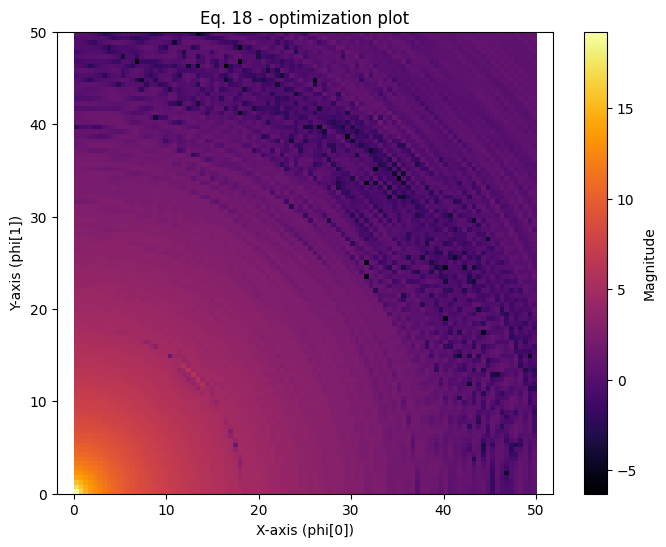

In [105]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
print(heatmap[:100,:50].shape)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [106]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(26), np.int64(26))
x: 13.131413131313131, y: 13.131413131313131


np.float64(-454.9370967652401)

In [30]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

In [31]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    #S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:2].flatten(), data_fourier) for n in range(len(phis)))

    # Find the index of the minimum value in S_signals
    #min_index = np.argmin(S_signals)

    # Convert the flat index to 2D index
    #min_index_2d = np.unravel_index(min_index, (gridsize, gridsize))

    # Get the corresponding x and y values
    #epsbar_x = x_values[min_index_2d[1]]
    #epsbar_y = y_values[min_index_2d[0]]

    result = minimize(D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_), method="L-BFGS-B")

    #result = differential_evolution(D_KL, bounds, args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_))

    #result1 = differential_evolution(D_KL3_entropy, bounds1, args=(phi_bar_last_x_, phi_bar_last_y_, result.x[0], result.x[1]))

    return np.array([[result.x[0]], [result.x[1]], [result.x[2]], [result.x[3]]])


def message_passing(N_iter = 100, N = 10):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[5], [5], [0], [0]])]
    phi_eq18 = [np.array([[5], [5], [0], [0]])]
    phi_barbar_list = [np.array([[0.1,0,0,0], [0,0.1,0,0], [0,0,0,0], [0,0,0,0]])]

    Lambda_a = np.diagflat([0.1,0.1,0.1,0.1])


    for n in tqdm(range(N)):
        D_KL = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.000], [0.000]])))
        eps_bar_list.append(eps_bar)
        phi_eq18.append(eps_bar_list[n])
        eps_barbar_list.append(np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e20,0], [0,0,0,1e20]]))

        beta = np.zeros((4,4))
        alpha = n+1

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)):
                if i-n == 0:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                    
                if n > 0:
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
        
        if n > 0:
            Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))

        
    
    return phi_bar_list, phi_barbar_list, phi_eq18

In [32]:
mrblat_data, mrblat_data_phibarbar, eq18 = message_passing()

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


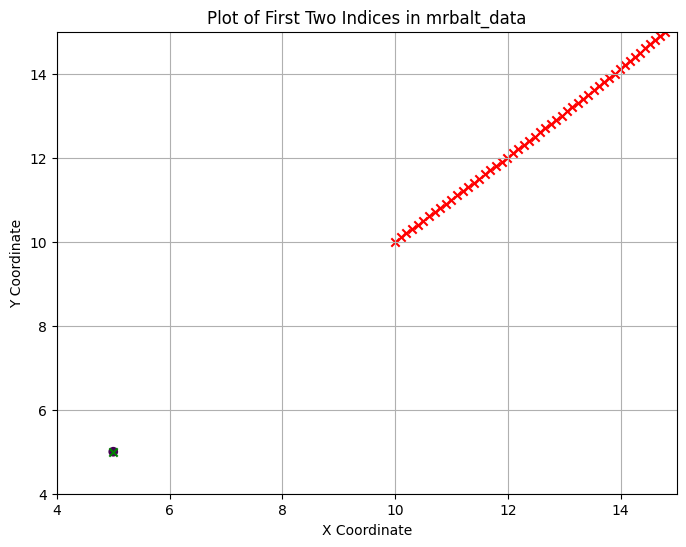

In [33]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

x_coords1 = [data[0, 0] for data in eq18]
y_coords1 = [data[1, 0] for data in eq18]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.scatter(x_coords1, y_coords1, c='green', marker='x')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x')
plt.xlim([4, 15])
plt.ylim([4, 15])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of First Two Indices in mrbalt_data')
plt.grid(True)
plt.show()

In [34]:
mrblat_data, mrblat_data_phibarbar

([array([[5],
         [5],
         [0],
         [0]]),
  array([[0.5159066 ],
         [0.47098687],
         [0.        ],
         [0.        ]]),
  array([[0.44078891],
         [0.12280644],
         [0.        ],
         [0.        ]]),
  array([[ 4.18609215e+03],
         [-5.20547849e+03],
         [-5.34732763e-10],
         [-1.52649826e-10]]),
  array([[ 4.18550030e+03],
         [-5.20474102e+03],
         [-6.86771019e-10],
         [-6.79159756e-10]]),
  array([[ 4.18550025e+03],
         [-5.20473945e+03],
         [-2.56641263e-13],
         [-2.55099964e-13]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-1.61897719e-15],
         [ 1.48487879e-15]]),
  array([[ 4.18550350e+03],
         [-5.20474218e+03],
         [-3.82648614e-17],
         [ 3.82667758e-17]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-2.78228025e-20],
         [ 2.80030114e-20]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-9.1

In [35]:
results = np.zeros((71, 4))

results[0] = np.array(([5, 5, 0.5, 0.5]))  # Initialize results as a list of lists

bounds = [(5,50), (5,50), (0.01, 10), (0.01, 10)]

for n in tqdm(range(70)):
    print(n)

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    #bounds = [(results[n-1, 0]-10,results[n-1, 0]+10), (results[n-1, 0]-10,results[n-1, 0]+10)]
    #print(bounds)
    result = minimize(D_KL, (results[n][0], results[n][1], 0.5, 0.5), args=(data_fourier, results[n][0], results[n][1]), method="L-BFGS-B")
    #result = differential_evolution(D_KL, [(5,50), (5,50), (0.01, 10), (0.01, 10)], args=(data_fourier, results[n][0], results[n][1]))

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

  0%|          | 0/70 [00:00<?, ?it/s]

0


  1%|▏         | 1/70 [00:00<00:56,  1.22it/s]

1


  3%|▎         | 2/70 [00:01<00:38,  1.75it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_33180\3163116464.py:30: RuntimeWarning: invalid value encountered in log
  entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)


2


  4%|▍         | 3/70 [00:01<00:32,  2.05it/s]

3


  6%|▌         | 4/70 [00:02<00:45,  1.45it/s]

4


  6%|▌         | 4/70 [00:03<00:53,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([4, 20])
plt.ylim([4, 50])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results' is not defined